In [1]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import re, glob
import os, sys
from scipy import stats

import spotipy                          # Set up a config file with ckey and skey. These are available if you go
from spotipy.oauth2 import SpotifyClientCredentials      # to https://developer.spotify.com/, click on Dashboard 
                                        # from the horizontal black menu, login with your normal user info. Click 
# Import Keys                           # on "create an app" if you haven't yet, it doesn't matter what you call it.
from config import ckey, skey            # Then click into
                                        # your project and you should see Client ID and Client Secret. Those are your 
                                        # ckey and skey. 

In [2]:
# Setting up Spotify API info

# Setting up Spotify API info

client_credentials_manager = SpotifyClientCredentials(client_id=ckey, client_secret=skey)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


##TIP: This next section assumes that you have already downloaded the csv files with the Top200 charts for the country you are working on:

Create a subfolder in the folder this notebook is located in called "input_files". Add the owid-covid-data.csv file there, you'll need that later. Then make another subfolder inside input_files called "spotify_top200_charts". Save the csv files you download there.
Go to https://spotifycharts.com
Choose the country you want to work on.
Download Weekly Top200 charts for 2019 and 2020, 1 chart per month. We agreed as a group to download the chart from last week of each month, to keep things consistent. Save them in the "spotify_top200_charts" folder you set up.

In [3]:
# Create dataframe from weekly chart data


path = r"input_files/spotify_top200_charts/*.csv"                # The path requires "".csv" at end of file name. 
                                                                 # This is to prevent the program from blowing up
                                                                 # when it hits some kind of hidden file. 

country_tracks_df = pd.read_csv(glob.glob(path)[0], header=1)    # Sets up **main dataframe** with data from **FIRST** file
string = str(glob.glob(path)[0])                                 # in the folder.
year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)   # This line extracts the year and month from the 
                                                                 # **file name**
country_tracks_df[['Year']] = year_month[0]
country_tracks_df[['Month']] = year_month[1]
country_tracks_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1]) 
Tot_Streams1 = country_tracks_df['Streams'].sum()                # Find out total streams in FIRST file in folder.
country_tracks_df[['Stream %']] = country_tracks_df['Streams'] / Tot_Streams1    # New column with % of streams

for file in glob.glob(path)[1:]:                                 # Now that you have the dataframe set up from the 
        temp_df = pd.read_csv(file, header=1)                    # first file in the folder, this iterates through 
        string = str(file)                                       # remaining files
        year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)
        #print (year_month)
        Tot_Streams2 = temp_df['Streams'].sum()
        temp_df[['Year']] = year_month[0]
        temp_df[['Month']] = year_month[1]
        temp_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1])
        temp_df[['Stream %']] = temp_df['Streams'] / Tot_Streams2
        country_tracks_df = pd.concat([country_tracks_df,        # Adds temperary datafame to end of main dataframe
                                       temp_df])                 # as new rows.  ¿¿¿???? 
        

                                                 
country_tracks_df = country_tracks_df.sort_values(['Year','Month'])  # Sort the new dataframe by year and month




                                                                 # You should get 4,800 rows (24 months x 200 
                                                                 # tracks per month)
country_tracks_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %
0,1,Secreto,Anuel AA,2888172,https://open.spotify.com/track/5W83ErFkO3aKAIS...,2019,01,2019-01,0.028116
1,2,Baila Baila Baila,Ozuna,2693711,https://open.spotify.com/track/7uH27oIt4a6cIFC...,2019,01,2019-01,0.026223
2,3,Adan y Eva,Paulo Londra,2448248,https://open.spotify.com/track/6FyRXC8tJUh863J...,2019,01,2019-01,0.023833
3,4,Calma - Remix,Pedro Capó,2216229,https://open.spotify.com/track/5iwz1NiezX7WWjn...,2019,01,2019-01,0.021575
4,5,NI BIEN NI MAL,Bad Bunny,2082242,https://open.spotify.com/track/278kSqsZIiYp8p3...,2019,01,2019-01,0.020270
...,...,...,...,...,...,...,...,...,...
195,196,En Tu Cuerpo - Remix,Lyanno,277680,https://open.spotify.com/track/3dEtfTtCXWW7N8W...,2020,12,2020-12,0.002014
196,197,Amigos,Galvan Real,277638,https://open.spotify.com/track/78OSjd1nAuqqFIH...,2020,12,2020-12,0.002013
197,198,NO TE HAS IDO Y YA TE EXTRAÑO,Aitana,276661,https://open.spotify.com/track/5XJIXRAM4ivaOit...,2020,12,2020-12,0.002006
198,199,Reggaetonera,Anuel AA,272769,https://open.spotify.com/track/6yVkakCN460KOVo...,2020,12,2020-12,0.001978


In [4]:
# Get Track IDs
track_names = country_tracks_df['Track Name'].to_list()           # Set up list of tracks to iterate through         
track_ids = []                                                    # Empty list to record track IDs into

for track in track_names:                                         # Heads up: with 4800 tracks to process, this takes
    song_results = sp.search(q=track, type='track', limit=1)      # awhile 
    try:
        track_ids.append(song_results['tracks']['items'][0]['id']) # Prevents program from blowing up - few tracks
        print (f"{track} song ID : {song_results['tracks']['items'][0]['id']}")   # Just to let you know it's working
    except IndexError:                                             # lack track ids
        track_ids.append(np.nan)     

Secreto song ID : 5W83ErFkO3aKAIS1WMi6u0
Baila Baila Baila song ID : 7mWFF4gPADjTQjC97CgFVt
Adan y Eva song ID : 6FyRXC8tJUh863JCkyWqtk
Calma - Remix song ID : 5iwz1NiezX7WWjnCgY5TH4
NI BIEN NI MAL song ID : 278kSqsZIiYp8p3QjYAqa8
Amanece song ID : 1LiN0Z98FkR1t0m8KmLcAH
Adictiva song ID : 0z24gh2KYWSfahslybQC4O
MALA song ID : 70uX4beGHc1nQikXveOknp
Mujer Bruja song ID : 4R8TsvDoKSSDVERlaphNBA
Ella Quiere Beber - Remix song ID : 3f5lA8nnc4YYF1qf78WpHw
Pa' Llamar Tu Atención (feat. MC Bin Laden) song ID : 2vEY3cNwXYxIG4fPAoN14q
MIA (feat. Drake) song ID : 116H0KvKr2Zl4RPuVBruDO
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Imposible song ID : 3ao3OVxHlb3C08vAaApUlm
Ta To Gucci (Remix) song ID : 7kuRvjpeUcn6qNV9IBXC2C
Vas A Quedarte song ID : 0fwIHsKXNEcb57u2um7z9I
Booty song ID : 6OCqV7mvGa48K7UkgkP0p1
Solo de Mi song ID : 5YOkA7qd2983FtBQnP8sYx
Taki Taki (with Selena Gomez, Ozuna & Cardi B) song ID : 4w8niZpiMy6qz1mntFA5uM
Con Calma song ID : 5w9c2J52mkdntKOmRLeM2m
Bubalu song ID : 7dNwJbsT

Perfect song ID : 0tgVpDi06FyKpA1z0VMD4v
Giant (with Rag'n'Bone Man) song ID : 5itOtNx0WxtJmi1TQ3RuRd
Chica Paranormal song ID : 3krzcyMKlRXjVkJFZqMN4t
Y, ¿Si Fuera Ella? - + Es + song ID : 6fiC7Kc7CMN2IKcLDCO6mp
Ojalá song ID : 73Cydqs0F5L35I3Qowtluk
Brindemos song ID : 5P8TXlZCMwru6DaMsIbbO3
No Tengo Nada song ID : 2eiebMTYM93kUajQdIMZOS
PPP - Remix song ID : 3jOn1ZdPldABfKQY4JBhov
Nadie Como Yo song ID : 2JYlYRQDiCMTRHchnSHIyq
La Plata (feat. Lalo Ebratt) song ID : 7Eso5mURNFprb5PmhOXDlf
Azukita song ID : 6tSaMs79oJxK3VZ7QFgoTj
Shotgun song ID : 4ofwffwvvnbSkrMSCKQDaC
Electricity (with Dua Lipa) song ID : 5N4erncE7kuUccm7zEmwzk
Natural song ID : 2FY7b99s15jUprqC0M5NCT
Love Someone song ID : 2JqnpexlO9dmvjUMCaLCLJ
BAGDAD - Cap.7: Liturgia song ID : 1zZ7vl1amOLI4GE5oUn0YB
Moonlight song ID : 0JP9xo3adEtGSdUEISiszL
Princesas song ID : 2geM54lztiqrOuy0wR13Xc
Familia (with Anuel Aa, feat. Bantu) - Spider-Man: Into the Spider-Verse song ID : 4Uy3kNxW2kB8AEoXljEcth
Arms Around You (feat. M

Pa Mí - Remix song ID : 7g8YaUQABMal0zWe7a2ijz
Hipócrita song ID : 4CbANooTL2aTHzJZqQ0Uvk
I Like It song ID : 58q2HKrzhC3ozto2nDdN4z
Solo (feat. Demi Lovato) song ID : 6kPJZM97LwdG9QIsT7khp6
Si Estuviésemos Juntos song ID : 35wvL50xvKpCHEJPxLOLPI
DI MI NOMBRE - Cap.8: Éxtasis song ID : 2Sfl7odHUmG7qc8SbqUyzE
Sin Culpa (feat. DrefQuila) song ID : 03PZ9C7f90TLbDk3dYjBd2
Un Veneno song ID : 4wNxcizGKSTfKm1emmO4yk
Poca Suerte song ID : 5NuVQ1a9vJxMeXJNMpXfZ7
Another One Bites The Dust - Remastered 2011 song ID : 57JVGBtBLCfHw2muk5416J
Duro y Suave song ID : 31M5m42C3EGlbydf9XB5to
In My Mind song ID : 0E9ZjEAyAwOXZ7wJC0PD33
Quiere Beber song ID : 0FDMH2ahuIVzCybwHJK9zh
Callao song ID : 3gu0fRSgFuc4FmrtIv0DnC
Don't Stop Me Now - Remastered 2011 song ID : 7hQJA50XrCWABAu5v6QZ4i
IDGAF song ID : 76cy1WJvNGJTj78UqeA5zr
Fuego song ID : 1eCNttxvk6L9sa3RZzvIUK
Déjalo song ID : 1gDN23O2aqeWX5NqjSnAbV
La player (Bandolera) song ID : 0VKkyBKCXyR99navhVRqcP
Mejor Que Tú song ID : 497YzH5kEsox8IJzN6wOTY

Sola song ID : 0Jr4zQh5i3vrKFEcXrhhxl
Nothing Breaks Like a Heart (feat. Miley Cyrus) song ID : 27rdGxbavYJeBphck5MZAF
Me Niego (feat. Ozuna & Wisin) song ID : 4ggiDYAkJ7Yk8d5xOr7Xjo
Giant (with Rag'n'Bone Man) song ID : 5itOtNx0WxtJmi1TQ3RuRd
bury a friend song ID : 4SSnFejRGlZikf02HLewEF
Está Rico song ID : 2wRkBumdItthjYP9XknImg
Besos En Guerra song ID : 5RPYHXSqcWaaiCbUbyfNAO
High Hopes song ID : 1rqqCSm0Qe4I9rUvWncaom
1, 2, 3 (feat. Jason Derulo & De La Ghetto) song ID : 4QtiVmuA88tPQiCOHZuQ5b
Lobos song ID : 1ZUOlY8R0Ms27uXEmcXT0W
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
Expertos song ID : 2a2MWHc7gtuecUWU9WIasb
Nadie song ID : 3YdshshEFnDVPZHovHozmE
Love Someone song ID : 2JqnpexlO9dmvjUMCaLCLJ
Me Rehúso song ID : 6De0lHrwBfPfrhorm9q1Xl
TELÉFONO song ID : 0vZi38VepxZWh0ACqYaXio
Te echo de menos song ID : 3gPOFPYLgpvQz0ZMwmv7NE
No te enamores song ID : 2mM3gZ0BbPwPPMelbA8vgt
La Cintura song ID : 6VUJQqyeQhAZHkQbSDqLtI
La Forma en Que Me Miras song ID : 6t94PGXYAuo9GbJEnMpPcW
L

La Plata (feat. Lalo Ebratt) song ID : 7Eso5mURNFprb5PmhOXDlf
Sucker song ID : 22vgEDb5hykfaTwLuskFGD
bury a friend song ID : 4SSnFejRGlZikf02HLewEF
Antes de Morirme (feat. Rosalía) song ID : 4Dl8bEzhAEGbcwkQawS1XG
Que Le De song ID : 08aYFNUTIOMGq93e2VSArQ
Créeme song ID : 0mqayP1Moez8gMZ06oq7rD
Old Town Road (feat. Billy Ray Cyrus) - Remix song ID : 6zpiwiexX8HpFCZLyIWKDv
Un Traguito song ID : 3x45jQfdx5HtXixx4YsoW6
Reggaeton song ID : 6yVkakCN460KOVol9ZazjH
La Romana song ID : 1khmgu0pveJbkbpbkyvcQv
R.I.P. (feat. Rita Ora & Anitta) song ID : 6JqpFboOH2bq9pzaYbkKBn
Pa Olvidarte (feat. Manuel Turizo) - Remix song ID : 2ktoFujjJtantyMoVdBJlX
SOS song ID : 30cSNer6TV8x2utjULVeQ5
Déjala Que Baile (with Alejandro Sanz & Arkano) song ID : 2KK9N6iBAisA0booTu3bGd
El Humo - Canción Original De La Película "Lo Dejo Cuando Quiera" song ID : 22umYdEW0MLHMPPFaZDlxE
Sola song ID : 0Jr4zQh5i3vrKFEcXrhhxl
Caro song ID : 5hTpBe8h35rJ67eAWHQsJx
Bajito song ID : 0Xf523k63exwTTdRmlkiqn
Happier song ID :

Secreto song ID : 5W83ErFkO3aKAIS1WMi6u0
Esclavo de Tus Besos song ID : 3g4UyIcQwutiG0TfW32GnX
No Te Veo - Remix song ID : 4NDIXOvmcKopGcRfs48IyV
Maldición song ID : 5IIXMynH8cxC8is6MaqdF7
Un Año song ID : 7onmX3EZ9Vq7v68aObV2sa
Amanece song ID : 1LiN0Z98FkR1t0m8KmLcAH
Guayo song ID : 4MR1AZhe1p0zTuH2HGhX9L
La Respuesta song ID : 2fOjendzUzepHwR9QrVyYF
No Me Conoce - Remix song ID : 4R8BJggjosTswLxtkw8V7P
11 PM song ID : 7KbF6AdprOXEEHlsq11Z6d
Ontas? song ID : 2XCyOEiZgavc6tH2wA1RCe
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
Adan y Eva song ID : 6FyRXC8tJUh863JCkyWqtk
Mujer Bruja song ID : 4R8TsvDoKSSDVERlaphNBA
Punto G song ID : 66AmCCC2MuswYD3sOLuuQe
Arcade song ID : 1Xi84slp6FryDSCbzq4UCD
Soltera song ID : 1c0hsvHLELX6y8qymnpLKL
El Efecto song ID : 4SJHHpKhcuXwDsCsPqshXj
Ella Quiere Beber - Remix song ID : 3f5lA8nnc4YYF1qf78WpHw
Pa' Llamar Tu Atención (feat. MC Bin Laden) song ID : 2vEY3cNwXYxIG4fPAoN14q
Te Vi song ID : 059bcIhyc2SBwm6sw2AZzd
Mi Persona Favorita song ID : 70fVcEP5pRrx

Caro song ID : 5hTpBe8h35rJ67eAWHQsJx
Callaita song ID : 2TH65lNHgvLxCKXM3apjxI
Otro Trago song ID : 4bTZeO72FwMa6wKOiqoynL
Soltera - Remix song ID : 1c0hsvHLELX6y8qymnpLKL
No Me Conoce - Remix song ID : 4R8BJggjosTswLxtkw8V7P
Cristina (feat. Shelow Shaq) song ID : 2egI1hFZDAYrkCgtepoore
Contando Lunares (feat. Cruz Cafuné) song ID : 6uW0PIRcyZLvkoonm763xD
Con Altura song ID : 2qG5sZ7Si6sdK74qLxedYM
Tal Vez song ID : 7Aiq4g8tSExAM2qUNkiHbZ
Verte Ir song ID : 4lzxJ4jCuFDXXGkE1LmpKR
Cuaderno song ID : 7anSoGdgtmJTAPZBzcPhO6
11 PM song ID : 7KbF6AdprOXEEHlsq11Z6d
Con Calma song ID : 5w9c2J52mkdntKOmRLeM2m
La Playa song ID : 70zg99pT51vB4wlMS7e4q7
Pa Mí - Remix song ID : 7g8YaUQABMal0zWe7a2ijz
Contra La Pared song ID : 37eGbhE1xVFSvcKkqGb6i1
Te Robaré song ID : 4PJ3umtW1aWdfh5EITHc6T
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Te Soñé De Nuevo song ID : 4oPnxZzoc8HM5Pva4FDeIp
Swing song ID : 6hIOunhsLUT66KQgZV5dMD
nan song ID : 0Psz3az3RIYfJpnsajBT8N
I Don't Care (with Justin Bieber) song ID

Ni La Hora song ID : 0d4iaUyHYJAGgMGcBl9G5x
Un Traguito song ID : 3x45jQfdx5HtXixx4YsoW6
Reggaeton song ID : 6yVkakCN460KOVol9ZazjH
Sirenas song ID : 4unOsvr9C2NqI9aJXrxpCy
Forever Happy song ID : 3Q8848wMFrcBiny6lVl4l0
Lo Malo - Operación Triunfo 2017 song ID : 7aJP1XcWcSU9w0eqSvaeZR
No te enamores song ID : 2mM3gZ0BbPwPPMelbA8vgt
1, 2, 3 (feat. Jason Derulo & De La Ghetto) song ID : 4QtiVmuA88tPQiCOHZuQ5b
Échame La Culpa song ID : 0mlAOSILGRys2IbvyOT5VJ
A Solas - Remix song ID : 1fXEkSum1vbTa3w0yvYzYW
Tan Buena song ID : 6I1JuzUGxTAD0kDY65fg1s
No Me Acuerdo song ID : 1G586ld1gbaECg4Bc6w40O
No Es Justo song ID : 4ENLcCIsIe3WQBklJSBQxK
Speechless (feat. Erika Sirola) song ID : 1rCcsYnmqbMYdkG7kS9GC5
Pega Pega song ID : 6IRgwlJMmQIxS9WXbQLAYX
Las Vegas song ID : 3AvVWGA4K2vVglI5kuzKQU
La Cartera song ID : 1g2Z2lOrwayOzDqOc8EfbR
Déjame Ser song ID : 30QMFZtiGzjKwyHiqQ3z7c
Nothing Breaks Like a Heart (feat. Miley Cyrus) song ID : 27rdGxbavYJeBphck5MZAF
Caliente song ID : 4pN7yDeBmmAud5lBt

Taki Taki (with Selena Gomez, Ozuna & Cardi B) song ID : 4w8niZpiMy6qz1mntFA5uM
R.I.P. (feat. Rita Ora & Anitta) song ID : 6JqpFboOH2bq9pzaYbkKBn
Besos En Guerra song ID : 5RPYHXSqcWaaiCbUbyfNAO
Perdón song ID : 0F6VPyUuJOPqt8E2uknv4R
MIA (feat. Drake) song ID : 116H0KvKr2Zl4RPuVBruDO
Don't Call Me Up song ID : 5WHTFyqSii0lmT9R21abT8
Nothing On You (feat. Paulo Londra & Dave) song ID : 2qRN7PWiHRLprw4FpDeI9N
Ya No Quiero Ná song ID : 2wDgqCVpMwj8CDvlvLs90p
Bohemian Rhapsody - Remastered 2011 song ID : 7tFiyTwD0nx5a1eklYtX2J
Princesas song ID : 2geM54lztiqrOuy0wR13Xc
Mamacita (feat. Farruko) song ID : 7iwhbx1YQcQ675DTj6AmAb
Destino song ID : 3Wt6xO1jfjpvDNRi5fEPvA
Mona Lisa song ID : 0dbTQYW3Ad1FTzIA9t90E8
TELÉFONO song ID : 0vZi38VepxZWh0ACqYaXio
Esclavo de Tus Besos song ID : 3g4UyIcQwutiG0TfW32GnX
La Libertad song ID : 3DsLBZjoU5AYxZXsepHtsW
Soldi song ID : 26ky3sBMKv31Kpvil5pGDh
Go Loko (feat. Tyga, Jon Z) song ID : 1kK6DwzyXJSp58u5HYWwuD
YO LE LLEGO song ID : 0uIfrUwwg0Z7KTitul7E3T

Ella Quiere Beber - Remix song ID : 3f5lA8nnc4YYF1qf78WpHw
Aute Cuture song ID : 7dQFpbs34ufIEU745DVclf
Instagram song ID : 6z1kLsntE7FuzKZHZWrXYN
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Esa Carita Que Me Llevas song ID : 52Ib0v6LNJqR027XOdGsnP
Con La Miel En Los Labios song ID : 2QJcrJNa4KGxQ6bw0MH3Zx
Sucker song ID : 22vgEDb5hykfaTwLuskFGD
Punto G song ID : 66AmCCC2MuswYD3sOLuuQe
Mírame - Remix song ID : 53uKGbcMjEc2gIWbfmvpdS
MALAMENTE - Cap.1: Augurio song ID : 1B0BQaSRHxhI0AUlItY3LK
Sobrenatural song ID : 4Sd5521zmOneUxTmSxh7Fb
Lalala song ID : 51Fjme0JiitpyXKuyQiCDo
Te echo de menos song ID : 3gPOFPYLgpvQz0ZMwmv7NE
Vas A Quedarte song ID : 0fwIHsKXNEcb57u2um7z9I
Beautiful People (feat. Khalid) song ID : 4evmHXcjt3bTUHD1cvny97
En Cero song ID : 51uLQESb4VnYAbs5WtGxho
Serpiente Veneno (feat. Ele A El Dominio) song ID : 63c2jMnVyf8dtnbaQK910d
Latina (feat. Maluma) song ID : 00Ia46AgCNfnXjzgH8PIKH
No Te Preocupes por Mi song ID : 5G3hFb8E9rMlKbdyDY4Vzh
Por Eso Vine song ID : 5qN1G8f

Swing song ID : 6hIOunhsLUT66KQgZV5dMD
Mi Morena song ID : 2CZuHgNRWhUBKMBii68z4G
Runaway song ID : 0TCmhnbMpw5zwPsTvlXTJi
HP song ID : 1LIqNVhaIgxXUt2eVoIQJ3
Me llama song ID : 5hEM0JchdVzQ5PwvSfITeX
5 Sentidos song ID : 7chjOPhoxbpRYSrO1rvdnu
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Mírame - Remix song ID : 53uKGbcMjEc2gIWbfmvpdS
Kemba Walker song ID : 38kLHBjtWJaPXcyFhwRVtI
Otro Trago song ID : 4bTZeO72FwMa6wKOiqoynL
Ibiza song ID : 1h9P5WJwyvK8OB7O2YiXgp
Hola Señorita song ID : 71MEWIf4Itr8Pd9OW5Mq7q
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
105 F Remix song ID : 1aUGxXCz9QimNkKeiJtzZ7
¿CÓMO TE VA, QUERIDA? song ID : 2p89F5HPntIfuJ1SnuPoeK
Soldi (feat. Maikel Delacalle) song ID : 1GVBnZF3tHJiWzdCSgg75Z
Date La Vuelta song ID : 5lwVd35Zg6DJ4qibVMq99H
Disparos song ID : 2F75mXaavRl0hm3rtM15cq
Pa Mí - Remix song ID : 7g8YaUQABMal0zWe7a2ijz
Celébrate song ID : 26IEVYmeFletNA10cOkdBb
Bellaquita song ID : 1tpbAGsGpZee5jDHMcLrUJ
La Playa song ID : 70zg99pT51vB4wlMS7e4q7
Cont

Lola Bunny song ID : 43RhkG7UfuzxWlGW5PLKRc
Si por mi fuera song ID : 5z9a61fPYYlb2hV0GLVYaB
Apriétala song ID : 0VLIfeftkYpJgzqUvJc0BP
OTRO CHEKE song ID : 1zzaawknHz9bMofpqN1wVS
Velitas song ID : 7q3NthaBqFI6s0WnAlnIvq
QUE PRETENDES song ID : 25ZAibhr3bdlMCLmubZDVt
ORGULLO song ID : 66FcNbmyOuU02IguDLLDwA
Con Altura song ID : 2qG5sZ7Si6sdK74qLxedYM
Qué Bonito Es Querer song ID : 7Jcvu13qlP4km0uDX9p2pZ
Si Se Da - Remix song ID : 6K5BsR04ijf3FHNzjbaagD
Mirándote song ID : 2JL9vwiXScRaXcNZScScaV
Bésame song ID : 0qlGn8vrV8LkGS0UjMSyLf
Nadie (feat. Sech & Sharo Towers) - Remix song ID : 6pNjmMB8FTMEcqGSgs7Mji
Atrévete song ID : 1q8NdCAQ9QUjpYiqzdd3mv
Loco Contigo (feat. J. Balvin & Tyga) song ID : 6osaMSJh9NguagEDQcZaKx
Me Equivocaré song ID : 4AFoE3HNniPmO29rPWw3FG
Que Tire Pa Lante song ID : 0iFROFTyditGLmb4CtqMBb
I Don't Care (with Justin Bieber) song ID : 3HVWdVOQ0ZA45FuZGSfvns
¿CÓMO TE VA, QUERIDA? song ID : 2p89F5HPntIfuJ1SnuPoeK
SI NO TE VEO song ID : 1SyBiNHbjrxMa93higpFce
Presie

Rueda song ID : 4NDHYPVJ5zLnR8yYZsMDsu
Adicto (with Anuel AA & Ozuna) song ID : 3jbT1Y5MoPwEIpZndDDwVq
Yo x Ti, Tu x Mi song ID : 7BlBVFwvbWvcwNcUarQmjk
Easy - Remix song ID : 0Cn8NxJZz7zUlsaA3rXoIU
Si Te Vas song ID : 6Y4PDQv4XjYjHLeLmvyOt0
Te Quemaste song ID : 4fj7e6Tc48Bmomwyz2Z2XC
Prendío song ID : 17VsiwLi1ovKYdVUqDieGC
Gan-Ga - Remix song ID : 27qRmG3zOWPvMYUkpPdQ1g
La Cama song ID : 2tGENA8xef0wABdHvyXwv9
La Rubia - Remix 2 song ID : 7KKTnv81z6DmfPIGsZWjOW
DJ No Pare (feat. Zion, Dalex, Lenny Tavárez) - Remix song ID : 1ndyl3wJCFs872XZ3ztPk6
Quizas song ID : 5Id5B3dxJZhPcV9GzgYZZe
Que Tire Pa Lante song ID : 0iFROFTyditGLmb4CtqMBb
Hasta Que Salga el Sol song ID : 0dDboLfmRNsTBscy4j3Rnl
Goteo song ID : 634fDJYRCr5yzqfFWa9rfS
De Tranquilote song ID : 1IDFcb3cjkj2dhv3UaxX9b
Hola - Remix song ID : 5stPVcRqb4qixbafP9e8lt
B11 (feat. Myke Towers) song ID : 4o1DxRjMCHDwBiOKv88rOl
Tabú song ID : 471HeGJPKw07MObixON0Um
Que Calor (with J Balvin & El Alfa) song ID : 7j7q6tCfEIlTeZtGjuBDT6


Inocente song ID : 6rXvMpWJbTyhSrVWye7jPE
Trueno: Bzrp Freestyle Sessions, Vol. 6 song ID : 4jTKJOFxaqEcm558JYi4Dh
Santa María (Feat. Busy Signal) song ID : 4R0sTxCaskwCPbzkfXHfWg
Guantanamera song ID : 1pqQ1BM3QJX1JaYz5yjN9L
Rebota - Remix song ID : 3dWpRjCmaHbroNahuSeX11
Contra La Pared song ID : 37eGbhE1xVFSvcKkqGb6i1
Pikete Italiano song ID : 2jGtKxyWHULVXbT75IWGZG
¿CÓMO TE VA, QUERIDA? song ID : 2p89F5HPntIfuJ1SnuPoeK
Piece Of Your Heart song ID : 1DFD5Fotzgn6yYXkYsKiGs
CANGURO song ID : 1mZOsAoN17Zn3MdeWjuaKb
Blood - Remix song ID : 0BoL0e5lLRCOEdOs55YcIF
Piropo song ID : 5YrjfKuFd0pMmYTGeRDV6X
La Mejor Versión de Mi - Remix song ID : 2dy3TKVDEbIeWxeIb8JWqZ
Besos En Guerra song ID : 5RPYHXSqcWaaiCbUbyfNAO
Te Soñé De Nuevo song ID : 4oPnxZzoc8HM5Pva4FDeIp
El Ciego song ID : 2P8NagN2tEzXRIufGuUPZO
Antes de Morirme (feat. Rosalía) song ID : 4Dl8bEzhAEGbcwkQawS1XG
Como Camarón song ID : 1VB4sadHjFcFklHcZuoROi
¿Qué Ha Pasao'? song ID : 2zkVH2daHyjS51g7PRJFDn
Bailemos song ID : 1ScD7XQ

Mi Error - Remix song ID : 0lbhKycRyqkOMKZ6thzfU4
La Playa song ID : 70zg99pT51vB4wlMS7e4q7
Llegó la Navidad song ID : 0Biqb9UJEsimAKNSxTuJYM
Fuego song ID : 1eCNttxvk6L9sa3RZzvIUK
Beautiful People (feat. Khalid) song ID : 4evmHXcjt3bTUHD1cvny97
MALAMENTE - Cap.1: Augurio song ID : 1B0BQaSRHxhI0AUlItY3LK
Suave - Remix song ID : 4phvdPGXE8MGXsTBhqB5ht
Swing song ID : 6hIOunhsLUT66KQgZV5dMD
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Soldadito marinero song ID : 0eVborSuxUeSg0meWYd9dZ
Secreto song ID : 5W83ErFkO3aKAIS1WMi6u0
Cuaderno song ID : 7anSoGdgtmJTAPZBzcPhO6
Te esperaré toda la vida song ID : 6MCPhEshiLRXgdFKqvr478
Lucid Dreams song ID : 285pBltuF7vW8TeWk8hdRR
Como Si Fueras a Morir Mañana song ID : 4aAfLSx9IthpC3Pw5pNk3E
Cuando Nadie Ve song ID : 71iAechwVKGu26pahzFL0k
Patek song ID : 76MjtLfZoTNc3BDqUVjuRH
24H song ID : 3OaunNUlXXs5e2PXtNAzzG
Underneath the Tree song ID : 3YZE5qDV7u1ZD1gZc47ZeR
Bonita song ID : 0atfY1ew83Ql9nNnJiD2t5
Ellos song ID : 1m5dYmul62r2orKdleLTYX
Mi Perso

Lose You To Love Me song ID : 4l0Mvzj72xxOpRrp6h8nHi
Diavla song ID : 0Hv33beQ6rSQPnRPlt83O8
Te esperaré toda la vida song ID : 6MCPhEshiLRXgdFKqvr478
Adan y Eva song ID : 6FyRXC8tJUh863JCkyWqtk
Cuerpo en Venta song ID : 2B94bbI1a4LyBpK1439oP7
5 Sentidos song ID : 7chjOPhoxbpRYSrO1rvdnu
C90 (Remix) song ID : 2b6i9zx3ULzKrNWmyP0ePD
Velitas song ID : 7q3NthaBqFI6s0WnAlnIvq
Mi Persona Favorita song ID : 70fVcEP5pRrxaIICY3DcPe
Bonita song ID : 0atfY1ew83Ql9nNnJiD2t5
QUE PRETENDES song ID : 25ZAibhr3bdlMCLmubZDVt
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Desde cero (con Melendi) song ID : 3RfmZepJErldBC4JXut6L9
Enchochado de Ti song ID : 6G8TNOdTBpBPmDdJAvoVhA
Te Robaré song ID : 4PJ3umtW1aWdfh5EITHc6T
Un Año song ID : 7onmX3EZ9Vq7v68aObV2sa
Atrévete song ID : 1q8NdCAQ9QUjpYiqzdd3mv
Soldadito marinero song ID : 0eVborSuxUeSg0meWYd9dZ
Piropo song ID : 5YrjfKuFd0pMmYTGeRDV6X
Mirándote song ID : 2JL9vwiXScRaXcNZScScaV
HIGHEST IN THE ROOM (feat. ROSALÍA & Lil Baby) - REMIX song ID : 7h0d2h0fUmzb

everything i wanted song ID : 3ZCTVFBt2Brf31RLEnCkWJ
Bésame song ID : 0qlGn8vrV8LkGS0UjMSyLf
Que Tire Pa Lante song ID : 0iFROFTyditGLmb4CtqMBb
Physical song ID : 3AzjcOeAmA57TIOr9zF1ZW
Despacio song ID : 203uubEQA07to1kbro35qQ
Soltera - Remix song ID : 1c0hsvHLELX6y8qymnpLKL
Otro Trago - Remix song ID : 4bTZeO72FwMa6wKOiqoynL
TBT song ID : 4s45VgkknMFkdiGoUcjxQU
Disparos song ID : 2F75mXaavRl0hm3rtM15cq
Me Quedo song ID : 301E9bwin8Gh2PCp0doIDz
Con Calma song ID : 5w9c2J52mkdntKOmRLeM2m
Si Te Vas song ID : 6Y4PDQv4XjYjHLeLmvyOt0
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Con La Miel En Los Labios song ID : 2QJcrJNa4KGxQ6bw0MH3Zx
LA CANCIÓN song ID : 0fea68AdmYNygeTGI4RC18
Calma - Remix song ID : 5iwz1NiezX7WWjnCgY5TH4
Lo siento song ID : 2VVqxQhALecXvaArlZSVXr
No Time To Die song ID : 73SpzrcaHk0RQPFP73vqVR
Que Calor (with J Balvin & El Alfa) song ID : 7j7q6tCfEIlTeZtGjuBDT6
PORFA song ID : 5CGRlMZ2SIEkgpnrMqoHnY
No Vuelvas Más song ID : 0mcBgVRVsvESTkEyVHt7Ue
Goteo song ID : 

Rueda song ID : 4NDHYPVJ5zLnR8yYZsMDsu
Hablamos Mañana song ID : 1V8XneTrX6kKeoxYbk4x6h
Ella No Quiere Rosé song ID : 6Aqeqb9rVNA1U6zuuxczQZ
4K song ID : 4xI3U4sDj1TPmO9Iz5TkYp
DOSIS song ID : 0cDumxvNKhydP1Cmon2S6E
A Dónde Vamos song ID : 3iaZkh6Cw1xyUkzJ53eYAV
No Me Conoce - Remix song ID : 4R8BJggjosTswLxtkw8V7P
Soldadito de Hierro song ID : 1wWSi1N5mBif8926JR78Ju
De Tranquilote song ID : 1IDFcb3cjkj2dhv3UaxX9b
Bichiyal song ID : 4j4w4CXm6BSr0s25wAWrrX
Tabú song ID : 471HeGJPKw07MObixON0Um
Presiento song ID : 0gYnWBpArbOOokGLDDhzyG
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
Te Quemaste song ID : 4fj7e6Tc48Bmomwyz2Z2XC
Callaita song ID : 2TH65lNHgvLxCKXM3apjxI
Que Malo song ID : 53v2u51nq3CxiKUNphRzP1
Contando Lunares (feat. Cruz Cafuné) song ID : 6uW0PIRcyZLvkoonm763xD
Pa Los Gustos Los Colores song ID : 6Bd9rs5gv25asdPDRog3ce
Qué Bonito Es Querer song ID : 7Jcvu13qlP4km0uDX9p2pZ
Fantasias song ID : 6mAN61JH0dzyZpWslS11jy
<3 song ID : 6Im9k8u9iIzKMrmV7BWtlF
Memories song

Ponte Pa' Mi song ID : 4C6BlqqMwjFzOXzqpTeoWR
China song ID : 2ksOAxtIxY8yElEWw8RhgK
Si Veo a Tu Mamá song ID : 41wtwzCZkXwpnakmwJ239F
death bed (coffee for your head) song ID : 7eJMfftS33KTjuF7lTsMCx
Atrévete song ID : 1q8NdCAQ9QUjpYiqzdd3mv
TBT song ID : 4s45VgkknMFkdiGoUcjxQU
Me Gusta song ID : 5Xhqh4lwJPtMUTsdBztN1a
Blanco song ID : 2rc7BkzO8qepMFAxHtOrXc
RITMO (Bad Boys For Life) song ID : 6cy3ki60hLwimwIje7tALf
Resistiré song ID : 0XFQb7pNfT90A7fRxjMWgz
4K song ID : 4xI3U4sDj1TPmO9Iz5TkYp
DOSIS song ID : 0cDumxvNKhydP1Cmon2S6E
La Santa song ID : 69vlMrzHwATKzupwNcUPyK
Hola - Remix song ID : 5stPVcRqb4qixbafP9e8lt
Indeciso song ID : 59s0s39NFWScuHDbHytI14
El Efecto - Remix song ID : 74j34STf8L6uADnTN69ohv
Indios y Vaqueros song ID : 3u5GmyJP2MU3tEJgyiAG2T
Physical song ID : 3AzjcOeAmA57TIOr9zF1ZW
Ahora Dice Que Me Ama song ID : 2Z3RqW9jfl62il0R4q8wQy
Toosie Slide song ID : 127QTOFJsJQp5LbJbu3A1y
3 de Abril song ID : 1c2oYPFni5vth1v9M7fYZb
Soldadito de Hierro song ID : 1wWSi1N5mBif

Yo Perreo Sola song ID : 0SqqAgdovOE24BzxIClpjw
CÓMO SE SIENTE - Remix song ID : 2tFwfmceQa1Y6nRPhYbEtC
Una Mala (Remix) song ID : 2maGaB3fNqQnyrG3FDiaW3
Sur y Norte song ID : 2uy5wXDZQcdd89PvDBSfyy
Elegí (feat. Dímelo Flow) song ID : 50ZC4PM7hywH27RcCfViau
Tak Tiki Tak song ID : 7gwwt1IaAWwmB7af0AcuBM
Se iluminaba song ID : 3VPOZWtj8mM89IiRNygxgS
El Efecto song ID : 4SJHHpKhcuXwDsCsPqshXj
Tattoo song ID : 1Srt81FTalOhRw7t7l8Yh8
Rain On Me (with Ariana Grande) song ID : 24ySl2hOPGCDcxBxFIqWBu
Diosa song ID : 3JHpk0DOTOzyh0777JFAky
Enemigos song ID : 3TXNuXIz469yziFDP7LcKD
Atrévete song ID : 1q8NdCAQ9QUjpYiqzdd3mv
Blinding Lights song ID : 0VjIjW4GlUZAMYd2vXMi3b
Confía song ID : 6vYQaurynY7NoHd6Iw85QM
Tu Eres Un Bom Bom - Remix song ID : 1Z9HnKFO3f332B9Ngp0Iyx
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
Morado song ID : 0oMtyJ3w2mCkztYRykM8sg
Si Tú La Quieres song ID : 35qwAQ3oZeKAMhR3hCV9IM
La Difícil song ID : 6NfrH0ANGmgBXyxgV2PeXt
La Cama - Remix song ID : 2tGENA8xef0wABd

5 Sentidos song ID : 7chjOPhoxbpRYSrO1rvdnu
Como Panas song ID : 07MrcfLozSPBfEI8GPOZgc
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
La Pared 360 song ID : 2w8SKQCnT2YQK1qCqKl2uW
Te Quemaste song ID : 4fj7e6Tc48Bmomwyz2Z2XC
La Jeepeta - Remix song ID : 1mohfLaTJtB2RplHLQVM70
El Manual song ID : 7kOf0qHO4Rcwk6QJifZDRJ
Hasta Que Dios Diga song ID : 06s3QtMJVXw1AJX3UfvZG1
Caramelo song ID : 3gD4J3RUHy4OUuZ3qAiaiG
PAM song ID : 0eeKDrQxjqNl5bX5VCHDcn
Sur y Norte song ID : 2uy5wXDZQcdd89PvDBSfyy
Carita de Inocente (feat. Myke Towers) - Remix song ID : 5kQre7o8ky5DXeEPcyaCR1
Fabuloso song ID : 3cg2Y9mIiYNdcPTLKaQgK3
Relación song ID : 35UUpTmrcFXNIVIN26ujXl
Mil Tequilas song ID : 3VvyD7SxO6SO3IuCODFAfW
Jangueo song ID : 1bRpSCFv6P2OUhciByeRYR
Pa toda la vida (feat. Mozart La Para) song ID : 6DDb7XRNUzeHmSoTbw5nmm
CÓMO SE SIENTE - Remix song ID : 2tFwfmceQa1Y6nRPhYbEtC
TKN (feat. Travis Scott) song ID : 4w47S36wQGBhGg073q3nt7
PORFA song ID : 5CGRlMZ2SIEkgpnrMqoHnY
Hola, Nena (feat. Omar Montes) s

Negro song ID : 0eB1AsERUb23HWSqmH1NBS
Ferrari song ID : 4mbb7hmfDR6M9cQaLdYSFd
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
Some Say song ID : 7C1trmcQQ5n5RNy4l6ziCv
Baila Conmigo (feat. Kelly Ruiz) song ID : 4Clmg1g8n2yBYG13Z1oSdG
Soltera - Remix song ID : 1c0hsvHLELX6y8qymnpLKL
LA CANCIÓN song ID : 0fea68AdmYNygeTGI4RC18
Gentleman song ID : 26spalP6x2gUAab8rwB8dQ
BENDICIONES song ID : 2CoMYp2uIKsT09nreEZnZn
Zorra song ID : 30t9smohiwcsWePn1V18Ce
Fuego song ID : 1eCNttxvk6L9sa3RZzvIUK
El Hipo song ID : 3CCPAxHcGuTL43u4U9euVo
Vete song ID : 5DxXgozhkPLgrbKFY91w0c
Como Camarón song ID : 1VB4sadHjFcFklHcZuoROi
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
La Presión song ID : 0LXk0yWcGfACtMKX0igobq
THE SCOTTS song ID : 39Yp9wwQiSRIDOvrVg7mbk
Party Girl song ID : 5RqR4ZCCKJDcBLIn4sih9l
Donde song ID : 0SpK2s8gJnetHIuzSBqgta
Somo o No Somos song ID : 3YeImruYgPnQtn4QgHqi04
La Bella y la Bestia song ID : 0G0p7mc4wEaQTsUpzEmkEs
Borracho De Amor song

La flaca song ID : 0ll9JAIrM3NVBOMl45sxSX
Princesas song ID : 2geM54lztiqrOuy0wR13Xc
A Dónde Vamos song ID : 3iaZkh6Cw1xyUkzJ53eYAV
Tutu song ID : 1nocRtwyNPVtGcIJqfgdzZ
Jangueo song ID : 1bRpSCFv6P2OUhciByeRYR
Batmóvil - Remix song ID : 3yOmf3oK10XIVRc99bwSyO
La Rubia - Remix 2 song ID : 7KKTnv81z6DmfPIGsZWjOW
Rueda song ID : 4NDHYPVJ5zLnR8yYZsMDsu
Señorita song ID : 0TK2YIli7K1leLovkQiNik
No Te Imaginas song ID : 6XBcXHqRUxlUlVmyv4Scjm
Que Mal Te Fue song ID : 7FhopXtl9z9YtD9NwUf9ss
Me Provocas song ID : 7sEwsJK7Ol0J6PFV9nioxu
Fantasias - Remix song ID : 0A37XY67wSdGqkGjtfW6aV
Un Verano En Mallorca song ID : 15tpxASJbTcAAfezvJfvuj
Dime A Ve song ID : 0HMTIZ3iQ6QNjBaD9IE7ZZ
Bobo song ID : 3LnQ9Umk47JGP5r7PbTPLp
Bésame song ID : 0qlGn8vrV8LkGS0UjMSyLf
Pirueta (with Arcangel, Chencho Corleone, feat. Wisin & Yandel, Myke Towers) song ID : 5tx7TTJEcrV5642l0Sn2sD
Hola - Remix song ID : 5stPVcRqb4qixbafP9e8lt
Break My Heart song ID : 017PF4Q3l4DBUiWoXk4OWT
Toosie Slide song ID : 127QTOFJsJQ

Como Si Fueras a Morir Mañana song ID : 4aAfLSx9IthpC3Pw5pNk3E
Me Vale song ID : 2bgzjBJcfn0r0HkJ0N2Lzx
Pegamos Tela song ID : 4punHldq7Jfx0Plu7SdjQ0
Roses - Imanbek Remix [Latino Gang] song ID : 2JCOFv3vvv6HIfw7QOqpIz
Fuera De Mi Mente song ID : 7bsqRe39lKOYX45FZpzP9o
Bajo La Mesa song ID : 7BEPdOI0neT6p7PnLViqmH
A Correr los Lakers (Remix) song ID : 29KkQi7wKF6IdOjwU8infb
Eso Que Tú Me Das song ID : 40tFJtuES1da2fg0OurUdI
DOSIS song ID : 0cDumxvNKhydP1Cmon2S6E
Diablo en Mujer song ID : 5VImGHyEZhJz7hf0YTTi4t
Dime Bbsita song ID : 5mBWQ675Eb4j4fn6iuNnOe
La Difícil song ID : 6NfrH0ANGmgBXyxgV2PeXt
La Calle song ID : 1SVm64B4Ry7dqFSxHY8e65
death bed (coffee for your head) song ID : 7eJMfftS33KTjuF7lTsMCx
Laugh Now Cry Later (feat. Lil Durk) song ID : 2SAqBLGA283SUiwJ3xOUVI
Qué Bonito Es Querer song ID : 7Jcvu13qlP4km0uDX9p2pZ
Mi Niña song ID : 2bgcUk2A3jjKbCJ7KPquTi
WAP (feat. Megan Thee Stallion) song ID : 4Oun2ylbjFKMPTiaSbbCih
Muévelo song ID : 4VgYtXCVJ7IbWAZ5ryfvEQ
Contando Lunares

Victoria song ID : 2BxzmBb2uqwnpyVuJqIIV9
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
Quédate conmigo song ID : 1OGMnhR2rzajraPPTlsqmX
Prendio (Remix) song ID : 17VsiwLi1ovKYdVUqDieGC
Quiéreme Mientras Se Pueda song ID : 34LI7rwi9H8w2S5KTHnv1M
Me Vale song ID : 2bgzjBJcfn0r0HkJ0N2Lzx
Me Gusta (with Cardi B & Myke Towers) song ID : 7e1VoRlNumuEkXlITMHKLE
ADMV song ID : 3eJMSq78dDaFb7VvhNFnq6
Before You Go song ID : 2gMXnyrvIjhVBUZwvLZDMP
Batmóvil - Remix song ID : 3yOmf3oK10XIVRc99bwSyO
Normal song ID : 5fQBa4wkmq28xpSLOQ202K
Safaera song ID : 2DEZmgHKAvm41k4J3R2E9Y
Hola, Nena (feat. Omar Montes) song ID : 2EAwcFW9NeuhnZ0q5aYhFL
Holy (feat. Chance The Rapper) song ID : 5u1n1kITHCxxp8twBcZxWy
Rojo song ID : 4zrkgzHl26rkCADbWe1PKw
China song ID : 2ksOAxtIxY8yElEWw8RhgK
La Presión song ID : 0LXk0yWcGfACtMKX0igobq
TKN (feat. Travis Scott) song ID : 4w47S36wQGBhGg073q3nt7
Amarillo song ID : 6OsbuHK5jQ626AAius3Cqx
El Farsante song ID : 5EId1m4DNwTf3at31w8bPJ
Como Si Fueras a Morir 

Flamenkito song ID : 1PCdz8GAZR1i7U5v7dKNMi
Si Tú La Quieres song ID : 35qwAQ3oZeKAMhR3hCV9IM
Mil Tequilas song ID : 3VvyD7SxO6SO3IuCODFAfW
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
Nunca Estoy song ID : 6N4ioa3XSbvjmwdVEERl8F
KHEA: Bzrp Music Sessions, Vol. 34 song ID : 7bidsoy3nzCDNYzAzrV7NN
No Se Da Cuenta song ID : 0wkr4KqObqC55h4U9wqwKn
Cucu song ID : 7gSQBj6btPUfsA7zBfKhDy
Pa toda la vida (feat. Mozart La Para) song ID : 6DDb7XRNUzeHmSoTbw5nmm
Dime Cuantas Veces (Remix) [feat. Justin Quiles] song ID : 4MWb6mltydQn84NrTm7Gpl
Relación song ID : 35UUpTmrcFXNIVIN26ujXl
Normal que se lo crea (feat. Keen Levy) song ID : 5SuAVjvO7r7n0v6ctuJ4L6
Hasta Que Dios Diga song ID : 06s3QtMJVXw1AJX3UfvZG1
4 besos song ID : 49QwoSLuV69Fd8bwTqdZvs
Quiéreme Mientras Se Pueda song ID : 34LI7rwi9H8w2S5KTHnv1M
Pegao / Me Miro y La Mire (TikTok Hit) song ID : 4Pzk85DqWoLqptyA5IlhLk
Amantes y Amigos song ID : 1UHcnP31sAKOJFrEnyRNUz
Breaking Me song ID : 3H7ihDc1dqLriiWXwsc2po
Santería song ID : 2

Se Te Nota (with Guaynaa) song ID : 11EnQRgRMJwMAesfkB5pnu
Polvo song ID : 68mrW6gXHgupgSiDHgaDi5
La Curiosidad song ID : 4HYDUMY0xSpeBr0AMY9cUz
Tussi song ID : 4vjVdfdBHnUiaFCcUa3gfn
Jeans song ID : 3GtnId3Cm1Xa6joCj08nzW
Como Estrellas song ID : 7GcN9q4AAH4uzQKvyuvByT
Mood (feat. iann dior) song ID : 4jPy3l0RUwlUI9T5XHBW2m
Mami song ID : 0TUW9faHNaBmi89wsYGp9y
Don Don song ID : 3kml9ZdpT7UYk1ugkjqOzt
cómo te va? song ID : 6Vy53iriyX8Vqx0V68Jzn2
Bonita song ID : 0atfY1ew83Ql9nNnJiD2t5
Hecha Pa' Mi song ID : 3VvA1wSxukMLsvXoXtlwWx
Parce (feat. Justin Quiles) song ID : 4RJz8NfIe09gpKMiRUWKhJ
Tattoo - Remix with Camilo song ID : 4ZRrLHqzhGRXYj2qcB4s5S
Tu Foto Del DNI song ID : 1eWWdO6oIBdJT8SCXaYCYV
UN DIA (ONE DAY) (Feat. Tainy) song ID : 0EhpEsp4L0oRGM0vmeaN5e
Lonely (with benny blanco) song ID : 4y4spB9m0Q6026KfkAvy9Q
Prisoner (feat. Dua Lipa) song ID : 5JqZ3oqF00jkT81foAFvqg
Batmóvil - Remix song ID : 3yOmf3oK10XIVRc99bwSyO
34 Amor y Mafia song ID : 6Vi8rWobVwobca5fR5WHVG
Nunca Estoy

No Te Debí Besar song ID : 1KdwnsWOvhM53vezy5ROuf
Morado song ID : 0oMtyJ3w2mCkztYRykM8sg
TKN (feat. Travis Scott) song ID : 4w47S36wQGBhGg073q3nt7
LA CANCIÓN song ID : 0fea68AdmYNygeTGI4RC18
Qué Bonito Fue song ID : 3ppzEzYnSKIBZ2tndbmOLp
Llorando en la Limo (feat. Alizzz) song ID : 3YURfhPPT7GipmI7pIj0m3
Princesas song ID : 2geM54lztiqrOuy0wR13Xc
Ignorantes song ID : 3wYRLYuO1M88d8woWUIxct
DÁKITI song ID : 47EiUVwUp4C9fGccaPuUCS
Tú Me Dejaste De Querer song ID : 0XinBYhf1X3kdvKQHOX971
LA NOCHE DE ANOCHE song ID : 2XIc1pqjXV3Cr2BQUGNBck
BICHOTA song ID : 7vrJn5hDSXRmdXoR30KgF1
Hecha Pa' Mi song ID : 3VvA1wSxukMLsvXoXtlwWx
Bandido song ID : 1xK1Gg9SxG8fy2Ya373oqb
La Nota song ID : 7ndTONDDRFGiPnnhOzOXxq
Nathy Peluso: Bzrp Music Sessions, Vol. 36 song ID : 78SeXVRJ7KCqVmOwTiFjnI
Chica Ideal song ID : 15QlXiHvifaxPve7KSlFel
BEBÉ song ID : 7D7EH7MGyNHWSkqrszerI1
Vida de Rico song ID : 73nAK3HgQK8dak83Y2WQ8F
A Un Paso De La Luna song ID : 6EQR7Y5vVZFiPD0RUECIDv
Blin Blin song ID : 4QsjS4W7

TE DESEO LO MEJOR song ID : 23XjN1s3DZC8Q9ZwuorYY4
Lemonade (feat. Gunna, Don Toliver & NAV) song ID : 7hxHWCCAIIxFLCzvDgnQHX
Blinding Lights (with ROSALÍA) - Remix song ID : 7MXgrcOQAJ5VwSNUL0lDd3
SORRY PAPI song ID : 5jZ32WOU7sqzDYbzINwMUk
Locura song ID : 5379uuUPHodsdVhy8pIAAr
Pa toda la vida (feat. Mozart La Para) song ID : 6DDb7XRNUzeHmSoTbw5nmm
Before You Go song ID : 2gMXnyrvIjhVBUZwvLZDMP
Amarillo song ID : 6OsbuHK5jQ626AAius3Cqx
ANTES QUE SE ACABE song ID : 7kjEqI6eZ7YlFrGhxixnlN
Morado song ID : 0oMtyJ3w2mCkztYRykM8sg
Si por mi fuera song ID : 5z9a61fPYYlb2hV0GLVYaB
Prendio (Remix) song ID : 17VsiwLi1ovKYdVUqDieGC
Soldadito marinero song ID : 0eVborSuxUeSg0meWYd9dZ
Diosa song ID : 3JHpk0DOTOzyh0777JFAky
Physical song ID : 3AzjcOeAmA57TIOr9zF1ZW
Savage Love (Laxed - Siren Beat) song ID : 1xQ6trAsedVPCdbtDAmk0c
34+35 song ID : 6Im9k8u9iIzKMrmV7BWtlF
Madrid (feat. Myke Towers) song ID : 19OXtYzrJyCrQvTbfukt4H
Therefore I Am song ID : 54bFM56PmE4YLRnqpW6Tha
Zinedine song ID : 6D

In [5]:
# Add Track IDs to dataframe

country_tracks_df['Track ID'] = track_ids                  # Add new column with track IDs

In [6]:
# Drop empty songs and export dataframe to csv to back it up

clean_country_tracks_df = country_tracks_df.dropna(how='any')           # Use .dropna() to remove rows with missing data

clean_country_tracks_df.to_csv("output_files/1_tracks_with_track_ids.csv", index = False)  # Back up to .csv

In [7]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_track_ids_df = pd.read_csv("output_files/1_tracks_with_track_ids.csv")

country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID
0,1,Secreto,Anuel AA,2888172,https://open.spotify.com/track/5W83ErFkO3aKAIS...,2019,1,2019-01,0.028116,5W83ErFkO3aKAIS1WMi6u0
1,2,Baila Baila Baila,Ozuna,2693711,https://open.spotify.com/track/7uH27oIt4a6cIFC...,2019,1,2019-01,0.026223,7mWFF4gPADjTQjC97CgFVt
2,3,Adan y Eva,Paulo Londra,2448248,https://open.spotify.com/track/6FyRXC8tJUh863J...,2019,1,2019-01,0.023833,6FyRXC8tJUh863JCkyWqtk
3,4,Calma - Remix,Pedro Capó,2216229,https://open.spotify.com/track/5iwz1NiezX7WWjn...,2019,1,2019-01,0.021575,5iwz1NiezX7WWjnCgY5TH4
4,5,NI BIEN NI MAL,Bad Bunny,2082242,https://open.spotify.com/track/278kSqsZIiYp8p3...,2019,1,2019-01,0.020270,278kSqsZIiYp8p3QjYAqa8
...,...,...,...,...,...,...,...,...,...,...
4770,196,En Tu Cuerpo - Remix,Lyanno,277680,https://open.spotify.com/track/3dEtfTtCXWW7N8W...,2020,12,2020-12,0.002014,3dEtfTtCXWW7N8WQ9FD29z
4771,197,Amigos,Galvan Real,277638,https://open.spotify.com/track/78OSjd1nAuqqFIH...,2020,12,2020-12,0.002013,4yVO0wOhXsZC1RuPgHP524
4772,198,NO TE HAS IDO Y YA TE EXTRAÑO,Aitana,276661,https://open.spotify.com/track/5XJIXRAM4ivaOit...,2020,12,2020-12,0.002006,5XJIXRAM4ivaOitRM4NuE4
4773,199,Reggaetonera,Anuel AA,272769,https://open.spotify.com/track/6yVkakCN460KOVo...,2020,12,2020-12,0.001978,6yVkakCN460KOVol9ZazjH


In [8]:
# Use API again to get audio features

danceability = []                                     # Set up empty lists to store data in
energy = []
valence = []
tempo = []

for track in country_track_ids_df['Track ID']:           # Heads up: this takes a long time
    
    try:
        feat_results = sp.audio_features([track])
        danceability.append(feat_results[0]['danceability'])
        energy.append(feat_results[0]['energy'])
        valence.append(feat_results[0]['valence'])
        tempo.append(feat_results[0]['tempo'])
        print (f"{track} Valence Score: {feat_results[0]['valence']}")  # Just to let you see it working                                 
    
    except TypeError:                                 # Covers you in case there is missing data
        danceability.append(np.nan)
        energy.append(np.nan)
        valence.append(np.nan)
        tempo.append(np.nan)
        

5W83ErFkO3aKAIS1WMi6u0 Valence Score: 0.706
7mWFF4gPADjTQjC97CgFVt Valence Score: 0.49
6FyRXC8tJUh863JCkyWqtk Valence Score: 0.72
5iwz1NiezX7WWjnCgY5TH4 Valence Score: 0.761
278kSqsZIiYp8p3QjYAqa8 Valence Score: 0.337
1LiN0Z98FkR1t0m8KmLcAH Valence Score: 0.889
0z24gh2KYWSfahslybQC4O Valence Score: 0.701
70uX4beGHc1nQikXveOknp Valence Score: 0.582
4R8TsvDoKSSDVERlaphNBA Valence Score: 0.763
3f5lA8nnc4YYF1qf78WpHw Valence Score: 0.697
2vEY3cNwXYxIG4fPAoN14q Valence Score: 0.678
116H0KvKr2Zl4RPuVBruDO Valence Score: 0.158
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
3ao3OVxHlb3C08vAaApUlm Valence Score: 0.913
7kuRvjpeUcn6qNV9IBXC2C Valence Score: 0.675
0fwIHsKXNEcb57u2um7z9I Valence Score: 0.168
6OCqV7mvGa48K7UkgkP0p1 Valence Score: 0.474
5YOkA7qd2983FtBQnP8sYx Valence Score: 0.15
4w8niZpiMy6qz1mntFA5uM Valence Score: 0.617
5w9c2J52mkdntKOmRLeM2m Valence Score: 0.656
7dNwJbsT0sg1le5kVugGJb Valence Score: 0.253
7H6ev70Weq6DdpZyyTmUXk Valence Score: 0.734
5vlEg2fT4cFWAqU5QptIpQ Valence Scor

3ee8Jmje8o58CHK66QrVC2 Valence Score: 0.473
0pqnGHJpmpxLKifKRmU6WP Valence Score: 0.666
5LpLb5QVCARfQhS4sCItbs Valence Score: 0.927
2JvzF1RMd7lE3KmFlsyZD8 Valence Score: 0.463
2jQiSYrwJehQAcuaaQrXnS Valence Score: 0.0911
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
5Z2OHghVzPn8qyCyIbDy4m Valence Score: 0.138
6Za3190Sbw39BBC77WSS1C Valence Score: 0.839
2QmsKag0YaqhAbpR9Nwmpn Valence Score: 0.804
2RSHsoi04658QL5xgQVov3 Valence Score: 0.0827
2ZRo7axmMPeSVUvDbGkJah Valence Score: 0.225
5w9c2J52mkdntKOmRLeM2m Valence Score: 0.656
6uW0PIRcyZLvkoonm763xD Valence Score: 0.709
5W83ErFkO3aKAIS1WMi6u0 Valence Score: 0.706
7mWFF4gPADjTQjC97CgFVt Valence Score: 0.49
5iwz1NiezX7WWjnCgY5TH4 Valence Score: 0.761
6FyRXC8tJUh863JCkyWqtk Valence Score: 0.72
7onmX3EZ9Vq7v68aObV2sa Valence Score: 0.534
2vEY3cNwXYxIG4fPAoN14q Valence Score: 0.678
1LiN0Z98FkR1t0m8KmLcAH Valence Score: 0.889
7kuRvjpeUcn6qNV9IBXC2C Valence Score: 0.675
3f5lA8nnc4YYF1qf78WpHw Valence Score: 0.697
278kSqsZIiYp8p3QjYAqa8 Valence Sc

5jGUJXnELDaDTgiRjD9lsg Valence Score: 0.816
72S6UNewVaLv3XqdcZ5J4L Valence Score: 0.494
6tSaMs79oJxK3VZ7QFgoTj Valence Score: 0.824
4yVO0wOhXsZC1RuPgHP524 Valence Score: 0.614
4vjpLMyL3ZO6aphdYr8XYw Valence Score: 0.534
11IzgLRXV7Cgek3tEgGgjw Valence Score: 0.466
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
00GbPd84bEyYS477RSymJW Valence Score: 0.797
2OWVCFTolecLiGZPquvWvT Valence Score: 0.439
3YURfhPPT7GipmI7pIj0m3 Valence Score: 0.371
4ofwffwvvnbSkrMSCKQDaC Valence Score: 0.754
2BgEsaKNfHUdlh97KmvFyo Valence Score: 0.603
5JeYtXkFiWoQ6nEjtURNMm Valence Score: 0.203
2rbDhOo9Fh61Bbu23T2qCk Valence Score: 0.296
6mdF6rXLXomvHuHsj03rBp Valence Score: 0.465
5CLGzJsGqhCEECcpnFQA8x Valence Score: 0.55
3HLXzyAOdpeNA5112jVVjT Valence Score: 0.0852
76NtMPMpA6fuUH4euMYZoD Valence Score: 0.628
3nN5n70vM1tAMWBDZaRbxS Valence Score: 0.683
7lHd6fXwVYy7W3VmOQhqYQ Valence Score: 0.321
4keoy2fqgwGnbWlm3ZVZFa Valence Score: 0.458
6cFZ4PLC19taNlpl9pbGMf Valence Score: 0.358
6Za3190Sbw39BBC77WSS1C Valence S

5pP7bNBzEPQlDI76502UiD Valence Score: 0.955
14eTSBjCDBNyXv8taIyzKd Valence Score: 0.774
1Ft3KKDbvXduw91Y9DZ2AB Valence Score: 0.728
3Fj47GNK2kUF0uaEDgXLaD Valence Score: 0.282
5WHTFyqSii0lmT9R21abT8 Valence Score: 0.234
0E9ZjEAyAwOXZ7wJC0PD33 Valence Score: 0.163
7qiZfU4dY1lWllzX7mPBI3 Valence Score: 0.931
78zQod0uqH9aeSEEAUNsRc Valence Score: 0.34
1wWSi1N5mBif8926JR78Ju Valence Score: 0.412
6kPJZM97LwdG9QIsT7khp6 Valence Score: 0.565
3OjNkFFZavF89xvRqWCXmU Valence Score: 0.245
5icOoE6VgqFKohjWWNp0Ac Valence Score: 0.181
58q2HKrzhC3ozto2nDdN4z Valence Score: 0.65
72S6UNewVaLv3XqdcZ5J4L Valence Score: 0.494
57JVGBtBLCfHw2muk5416J Valence Score: 0.756
1OUPXna2MCgAt3VNmXJBtg Valence Score: 0.865
4vjpLMyL3ZO6aphdYr8XYw Valence Score: 0.534
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
0VKkyBKCXyR99navhVRqcP Valence Score: 0.602
7iKLFfnQULROZ7XRxG6ive Valence Score: 0.853
0dWvKc40j9oBcmSpnQcZvg Valence Score: 0.474
6mdF6rXLXomvHuHsj03rBp Valence Score: 0.465
4unOsvr9C2NqI9aJXrxpCy Valence Sco

6z7mOTf4O20AApGsTNn7fC Valence Score: 0.194
1DnQiHRa2XnfwIf8qVl5C1 Valence Score: 0.675
7qiZfU4dY1lWllzX7mPBI3 Valence Score: 0.931
4aAfLSx9IthpC3Pw5pNk3E Valence Score: 0.373
7ef4DlsgrMEH11cDZd32M6 Valence Score: 0.592
2wRkBumdItthjYP9XknImg Valence Score: 0.674
2eD5bmknmcojiCxoKpvVTI Valence Score: 0.495
4NGbpyKrKMlJX4kP8iTQFJ Valence Score: 0.659
2swZ0X1njeU32SNJeBKIfW Valence Score: 0.848
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
2qxmye6gAegTMjLKEBoR3d Valence Score: 0.483
7D7EH7MGyNHWSkqrszerI1 Valence Score: 0.965
5pP7bNBzEPQlDI76502UiD Valence Score: 0.955
6mfu6jyFgvnXeTPQrYNs8d Valence Score: 0.473
2Sfl7odHUmG7qc8SbqUyzE Valence Score: 0.547
6ScJMrlpiLfZUGtWp4QIVt Valence Score: 0.773
5N5k9nd479b1xpDZ4usjrg Valence Score: 0.486
7M8K2ermHPnLJildw6F6EP Valence Score: 0.843
7z4oHxXTt01FquX2TekRWZ Valence Score: 0.367
2eiebMTYM93kUajQdIMZOS Valence Score: 0.615
2PxGGRmj5yunYdNF2Ud2vm Valence Score: 0.577
7DrluKkTviBwCc8AV3VGmf Valence Score: 0.881
7o0oY5wRcoV7oPuDhD2J1z Valence S

5itOtNx0WxtJmi1TQ3RuRd Valence Score: 0.606
4ENLcCIsIe3WQBklJSBQxK Valence Score: 0.689
0Jr4zQh5i3vrKFEcXrhhxl Valence Score: 0.331
5vHyWEoEyIJT5RhR1fcN7y Valence Score: 0.338
7A07Yu1dRND3RKDzbhKrDs Valence Score: 0.455
0gCPvo1GkbtPhMqg5Gbx1K Valence Score: 0.199
7ckO8bTkYT5YzwzwnZ6v5a Valence Score: 0.875
1G586ld1gbaECg4Bc6w40O Valence Score: 0.748
2JqnpexlO9dmvjUMCaLCLJ Valence Score: 0.274
3V8UKqhEK5zBkBb6d6ub8i Valence Score: 0.442
7aJP1XcWcSU9w0eqSvaeZR Valence Score: 0.964
0jvN7eQJJt4nxQzgQfZ1SP Valence Score: 0.543
1WSGTYKLEpKfNQYYW5Oymt Valence Score: 0.69
0Jr4zQh5i3vrKFEcXrhhxl Valence Score: 0.331
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
2xKvuZes9IeLf47ht1E0UK Valence Score: 0.289
5vlEg2fT4cFWAqU5QptIpQ Valence Score: 0.195
35wvL50xvKpCHEJPxLOLPI Valence Score: 0.158
2geM54lztiqrOuy0wR13Xc Valence Score: 0.328
6VUJQqyeQhAZHkQbSDqLtI Valence Score: 0.762
4aAfLSx9IthpC3Pw5pNk3E Valence Score: 0.373
340UVheS8z3ncW9TTUhAbc Valence Score: 0.538
27rdGxbavYJeBphck5MZAF Valence Sc

2KK9N6iBAisA0booTu3bGd Valence Score: 0.598
4fdlJwhZ99rUWZ7kXQmhQL Valence Score: 0.362
3DsLBZjoU5AYxZXsepHtsW Valence Score: 0.57
0vZi38VepxZWh0ACqYaXio Valence Score: 0.746
2YRvdf9cdS88y1wB1WhKoE Valence Score: 0.918
5PYQUBXc7NYeI1obMKSJK0 Valence Score: 0.385
1khmgu0pveJbkbpbkyvcQv Valence Score: 0.326
2vEY3cNwXYxIG4fPAoN14q Valence Score: 0.678
7kuRvjpeUcn6qNV9IBXC2C Valence Score: 0.675
6OCqV7mvGa48K7UkgkP0p1 Valence Score: 0.474
6LsAAHotRLMOHfCsSfYCsz Valence Score: 0.864
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
2XCyOEiZgavc6tH2wA1RCe Valence Score: 0.77
5RPYHXSqcWaaiCbUbyfNAO Valence Score: 0.783
2x0RZdkZcD8QRI53XT4GI5 Valence Score: 0.376
4HSCdZ6jerMGUSxaTklvNR Valence Score: 0.343
2YpeDb67231RjR0MgVLzsG Valence Score: 0.639
7Eso5mURNFprb5PmhOXDlf Valence Score: 0.961
1kK6DwzyXJSp58u5HYWwuD Valence Score: 0.131
1h9P5WJwyvK8OB7O2YiXgp Valence Score: 0.726
0eVborSuxUeSg0meWYd9dZ Valence Score: 0.324
2geM54lztiqrOuy0wR13Xc Valence Score: 0.328
6VUJQqyeQhAZHkQbSDqLtI Valence Sco

6MCPhEshiLRXgdFKqvr478 Valence Score: 0.85
7Jcvu13qlP4km0uDX9p2pZ Valence Score: 0.427
2KK9N6iBAisA0booTu3bGd Valence Score: 0.598
4txQPJDlvU72lC6EMhT7m9 Valence Score: 0.524
5G3hFb8E9rMlKbdyDY4Vzh Valence Score: 0.501
4vUmTMuQqjdnvlZmAH61Qk Valence Score: 0.668
3QwBODjSEzelZyVjxPOHdq Valence Score: 0.704
2VVqxQhALecXvaArlZSVXr Valence Score: 0.63
69seZxR4d4nr6EttlJnssw Valence Score: 0.964
7H6ev70Weq6DdpZyyTmUXk Valence Score: 0.734
6zw6EBrOdGTbKzC0djTOlD Valence Score: 0.796
0t3ZvGKlmYmVsDzBJAXK8C Valence Score: 0.163
1eCNttxvk6L9sa3RZzvIUK Valence Score: 0.94
6b2RcmUt1g9N9mQ3CbjX2Y Valence Score: 0.345
1pqQ1BM3QJX1JaYz5yjN9L Valence Score: 0.667
69O4w2LwIBoFk4yJMpPEJu Valence Score: 0.907
0eVborSuxUeSg0meWYd9dZ Valence Score: 0.324
4w8niZpiMy6qz1mntFA5uM Valence Score: 0.617
6JqpFboOH2bq9pzaYbkKBn Valence Score: 0.698
5RPYHXSqcWaaiCbUbyfNAO Valence Score: 0.783
0F6VPyUuJOPqt8E2uknv4R Valence Score: 0.961
116H0KvKr2Zl4RPuVBruDO Valence Score: 0.158
5WHTFyqSii0lmT9R21abT8 Valence Scor

7dQFpbs34ufIEU745DVclf Valence Score: 0.538
6z1kLsntE7FuzKZHZWrXYN Valence Score: 0.219
2VxeLyX666F8uXCJ0dZF8B Valence Score: 0.323
52Ib0v6LNJqR027XOdGsnP Valence Score: 0.447
2QJcrJNa4KGxQ6bw0MH3Zx Valence Score: 0.432
22vgEDb5hykfaTwLuskFGD Valence Score: 0.952
66AmCCC2MuswYD3sOLuuQe Valence Score: 0.903
53uKGbcMjEc2gIWbfmvpdS Valence Score: 0.78
1B0BQaSRHxhI0AUlItY3LK Valence Score: 0.53
4Sd5521zmOneUxTmSxh7Fb Valence Score: 0.114
51Fjme0JiitpyXKuyQiCDo Valence Score: 0.495
3gPOFPYLgpvQz0ZMwmv7NE Valence Score: 0.362
0fwIHsKXNEcb57u2um7z9I Valence Score: 0.168
4evmHXcjt3bTUHD1cvny97 Valence Score: 0.548
51uLQESb4VnYAbs5WtGxho Valence Score: 0.634
63c2jMnVyf8dtnbaQK910d Valence Score: 0.553
00Ia46AgCNfnXjzgH8PIKH Valence Score: 0.75
5G3hFb8E9rMlKbdyDY4Vzh Valence Score: 0.501
5qN1G8fSHq4Sv5FRoOkNGu Valence Score: 0.625
0eVborSuxUeSg0meWYd9dZ Valence Score: 0.324
2W4lpjqWOPPqN0OkPAVHmI Valence Score: 0.357
6sM2l0nxPaYvELuhzIMnoI Valence Score: 0.168
6MCPhEshiLRXgdFKqvr478 Valence Scor

26IEVYmeFletNA10cOkdBb Valence Score: 0.595
1tpbAGsGpZee5jDHMcLrUJ Valence Score: 0.765
70zg99pT51vB4wlMS7e4q7 Valence Score: 0.394
37eGbhE1xVFSvcKkqGb6i1 Valence Score: 0.598
4jTKJOFxaqEcm558JYi4Dh Valence Score: 0.496
4evmHXcjt3bTUHD1cvny97 Valence Score: 0.548
7onmX3EZ9Vq7v68aObV2sa Valence Score: 0.534
79l5JbcB7MVcjmYlvgq9KQ Valence Score: 0.847
2S93hylQBYLndMnaJuso8S Valence Score: 0.391
2EEmzqzM70CybVspgM7YRT Valence Score: 0.85
3GnzoWqvd6XvSRjli1uCUC Valence Score: 0.623
721Lxh9pNJJhNERON4Zjmw Valence Score: 0.418
6zegtH6XXd2PDPLvy1Y0n2 Valence Score: 0.334
71pEiUWwfDFiRO6RmFpnBf Valence Score: 0.885
5G3hFb8E9rMlKbdyDY4Vzh Valence Score: 0.501
6FyRXC8tJUh863JCkyWqtk Valence Score: 0.72
2QJcrJNa4KGxQ6bw0MH3Zx Valence Score: 0.432
23CsjGOYDQiJpX44BSn9TM Valence Score: 0.689
2YpeDb67231RjR0MgVLzsG Valence Score: 0.639
7fODjB7BrQTGqh0hogW6XD Valence Score: 0.811
1B0BQaSRHxhI0AUlItY3LK Valence Score: 0.53
0atfY1ew83Ql9nNnJiD2t5 Valence Score: 0.869
6K5BsR04ijf3FHNzjbaagD Valence Scor

17nYNma8AncLFqOBk6tu6m Valence Score: 0.937
7anSoGdgtmJTAPZBzcPhO6 Valence Score: 0.688
0LxAxw5XTiaLuTOCSSGhrB Valence Score: 0.419
3h8oIZTniP8KIrLhELvXin Valence Score: 0.842
6rXvMpWJbTyhSrVWye7jPE Valence Score: 0.857
301E9bwin8Gh2PCp0doIDz Valence Score: 0.884
2K3bjojp1sCLdMMoO5lJ2p Valence Score: 0.906
2F75mXaavRl0hm3rtM15cq Valence Score: 0.754
51Fjme0JiitpyXKuyQiCDo Valence Score: 0.495
2b8fOow8UzyDFAE27YhOZM Valence Score: 0.575
4evmHXcjt3bTUHD1cvny97 Valence Score: 0.548
4lzxJ4jCuFDXXGkE1LmpKR Valence Score: 0.553
21jGcNKet2qwijlDFuPiPb Valence Score: 0.553
31i8asUkiaRRRds39JaRUt Valence Score: 0.849
6G8TNOdTBpBPmDdJAvoVhA Valence Score: 0.531
1tpbAGsGpZee5jDHMcLrUJ Valence Score: 0.765
2egI1hFZDAYrkCgtepoore Valence Score: 0.869
38kLHBjtWJaPXcyFhwRVtI Valence Score: 0.596
7Aiq4g8tSExAM2qUNkiHbZ Valence Score: 0.561
1d1N1JZfKYI0Pj5TXzs4vy Valence Score: 0.57
0TCmhnbMpw5zwPsTvlXTJi Valence Score: 0.13
1mZOsAoN17Zn3MdeWjuaKb Valence Score: 0.952
1qdlys3D2hI2BV5qusTEFu Valence Sco

1q8NdCAQ9QUjpYiqzdd3mv Valence Score: 0.883
6W3sdKBGT1dccEhYuSAtBr Valence Score: 0.177
0e0BqjHEcb6pJAVJ7WZA7V Valence Score: 0.459
3RfmZepJErldBC4JXut6L9 Valence Score: 0.25
23zJcKwLf5CeaKVbFhrWgF Valence Score: 0.332
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
7KAveXwQ5xzdHT6GDlNIBu Valence Score: 0.599
43RhkG7UfuzxWlGW5PLKRc Valence Score: 0.0889
1wWSi1N5mBif8926JR78Ju Valence Score: 0.412
696DnlkuDOXcMAnKlTgXXK Valence Score: 0.457
7FbKipScVxkjQxQXwTd0gL Valence Score: 0.718
2F75mXaavRl0hm3rtM15cq Valence Score: 0.754
4l0Mvzj72xxOpRrp6h8nHi Valence Score: 0.0978
2VVqxQhALecXvaArlZSVXr Valence Score: 0.63
0Hv33beQ6rSQPnRPlt83O8 Valence Score: 0.739
0qlGn8vrV8LkGS0UjMSyLf Valence Score: 0.879
0VLIfeftkYpJgzqUvJc0BP Valence Score: 0.68
3HVWdVOQ0ZA45FuZGSfvns Valence Score: 0.842
0cDumxvNKhydP1Cmon2S6E Valence Score: 0.782
7q3NthaBqFI6s0WnAlnIvq Valence Score: 0.622
21jGcNKet2qwijlDFuPiPb Valence Score: 0.553
1tpbAGsGpZee5jDHMcLrUJ Valence Score: 0.765
21by4HhbV3w4uUNrotR02z Valence Sc

7Jcvu13qlP4km0uDX9p2pZ Valence Score: 0.427
0fea68AdmYNygeTGI4RC18 Valence Score: 0.429
3qQ6WFhcAx6LOH1UHz1c0U Valence Score: 0.219
5TTXEcfsYLh6fTarLaevTi Valence Score: 0.227
27qRmG3zOWPvMYUkpPdQ1g Valence Score: 0.396
1c0hsvHLELX6y8qymnpLKL Valence Score: 0.799
1KdwnsWOvhM53vezy5ROuf Valence Score: 0.62
0lizgQ7Qw35od7CYaoMBZb Valence Score: 0.591
0gYnWBpArbOOokGLDDhzyG Valence Score: 0.4
0mcBgVRVsvESTkEyVHt7Ue Valence Score: 0.836
6WrI0LAC5M1Rw2MnX2ZvEg Valence Score: 0.677
4HVzCG4ntiixZjPwOUFWHu Valence Score: 0.376
5w9c2J52mkdntKOmRLeM2m Valence Score: 0.656
5e50NiIlOc2YJIftHzoehd Valence Score: 0.527
5iwz1NiezX7WWjnCgY5TH4 Valence Score: 0.761
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
6AzKhCHOms83jvNVLsz0Bt Valence Score: 0.672
4AFoE3HNniPmO29rPWw3FG Valence Score: 0.726
5a1iz510sv2W9Dt1MvFd5R Valence Score: 0.363
301E9bwin8Gh2PCp0doIDz Valence Score: 0.884
4CMrdHWqic0usIZfTrKoI3 Valence Score: 0.511
7vQbuQcyTflfCIOu3Uzzya Valence Score: 0.806
5BhSZWrUa5xkZ2K7Ze5fVT Valence Scor

0gYnWBpArbOOokGLDDhzyG Valence Score: 0.4
4bTZeO72FwMa6wKOiqoynL Valence Score: 0.763
3OUPJPD1OmFd8gL7ztY9v8 Valence Score: 0.792
4z6wo6PJG4Fve45OXK6D9m Valence Score: 0.721
6Aqeqb9rVNA1U6zuuxczQZ Valence Score: 0.469
4T7SpjqFNSpfdAsN66DkiE Valence Score: 0.681
1nocRtwyNPVtGcIJqfgdzZ Valence Score: 0.94
4R8BJggjosTswLxtkw8V7P Valence Score: 0.58
0TK2YIli7K1leLovkQiNik Valence Score: 0.75
3YntiCUU0Xqq0B68FM3YAt Valence Score: 0.858
2TH65lNHgvLxCKXM3apjxI Valence Score: 0.244
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
7j7q6tCfEIlTeZtGjuBDT6 Valence Score: 0.46
0cDumxvNKhydP1Cmon2S6E Valence Score: 0.782
2qG5sZ7Si6sdK74qLxedYM Valence Score: 0.746
0iFROFTyditGLmb4CtqMBb Valence Score: 0.704
4AFoE3HNniPmO29rPWw3FG Valence Score: 0.726
1aUGxXCz9QimNkKeiJtzZ7 Valence Score: 0.741
0nbXyq5TXYPCO7pr3N8S4I Valence Score: 0.642
4punHldq7Jfx0Plu7SdjQ0 Valence Score: 0.855
5QXQy0f2q8wJNpPwJtjifx Valence Score: 0.549
3qQ6WFhcAx6LOH1UHz1c0U Valence Score: 0.219
634fDJYRCr5yzqfFWa9rfS Valence Score:

6WrI0LAC5M1Rw2MnX2ZvEg Valence Score: 0.677
7BlBVFwvbWvcwNcUarQmjk Valence Score: 0.579
113PlnpZbHd3WIqeYjhZWv Valence Score: 0.429
1Xnn1TPyr5h0hpRAT4B4EA Valence Score: 0.758
471HeGJPKw07MObixON0Um Valence Score: 0.553
3u5GmyJP2MU3tEJgyiAG2T Valence Score: 0.851
07MrcfLozSPBfEI8GPOZgc Valence Score: 0.379
4o1DxRjMCHDwBiOKv88rOl Valence Score: 0.195
4fj7e6Tc48Bmomwyz2Z2XC Valence Score: 0.718
6mAN61JH0dzyZpWslS11jy Valence Score: 0.788
1UozIJsPRJVXDRG08AgUQP Valence Score: 0.892
0gYnWBpArbOOokGLDDhzyG Valence Score: 0.4
7Jcvu13qlP4km0uDX9p2pZ Valence Score: 0.427
1OGMnhR2rzajraPPTlsqmX Valence Score: 0.347
2Trp0YqhfDVQbLBepoDS2q Valence Score: 0.55
4huB3db25M1GuvadoVtz6r Valence Score: 0.461
2Z3RqW9jfl62il0R4q8wQy Valence Score: 0.48
4phvdPGXE8MGXsTBhqB5ht Valence Score: 0.524
3iaZkh6Cw1xyUkzJ53eYAV Valence Score: 0.179
1IDFcb3cjkj2dhv3UaxX9b Valence Score: 0.889
2w8SKQCnT2YQK1qCqKl2uW Valence Score: 0.833
5RClLxkUvnMWFUQ3VAQEHj Valence Score: 0.829
6Bd9rs5gv25asdPDRog3ce Valence Score

69vlMrzHwATKzupwNcUPyK Valence Score: 0.586
0VjIjW4GlUZAMYd2vXMi3b Valence Score: 0.334
17VsiwLi1ovKYdVUqDieGC Valence Score: 0.754
6RyuoOJXNzlVWpfC5xQyeI Valence Score: 0.699
4VgYtXCVJ7IbWAZ5ryfvEQ Valence Score: 0.919
5zzbORcD0GwLY0wQHP1Xs1 Valence Score: 0.393
5stPVcRqb4qixbafP9e8lt Valence Score: 0.343
7sQKy5vlPQllr0k9IjYJv3 Valence Score: 0.676
2Z3RqW9jfl62il0R4q8wQy Valence Score: 0.48
5z9a61fPYYlb2hV0GLVYaB Valence Score: 0.634
0SqqAgdovOE24BzxIClpjw Valence Score: 0.453
2ksOAxtIxY8yElEWw8RhgK Valence Score: 0.609
59s0s39NFWScuHDbHytI14 Valence Score: 0.896
6cy3ki60hLwimwIje7tALf Valence Score: 0.667
4T7SpjqFNSpfdAsN66DkiE Valence Score: 0.681
5DxXgozhkPLgrbKFY91w0c Valence Score: 0.526
6WrI0LAC5M1Rw2MnX2ZvEg Valence Score: 0.677
4saHEjXw7O1NXJOzBkUKKG Valence Score: 0.879
1OGMnhR2rzajraPPTlsqmX Valence Score: 0.347
07MrcfLozSPBfEI8GPOZgc Valence Score: 0.379
4NqQaovM14WR2hNPMFxgjb Valence Score: 0.542
4s45VgkknMFkdiGoUcjxQU Valence Score: 0.639
047WmwIeerHyIUstFAEz5A Valence Sc

6NfrH0ANGmgBXyxgV2PeXt Valence Score: 0.761
0oMtyJ3w2mCkztYRykM8sg Valence Score: 0.781
1Z9HnKFO3f332B9Ngp0Iyx Valence Score: 0.521
6osaMSJh9NguagEDQcZaKx Valence Score: 0.371
3JHpk0DOTOzyh0777JFAky Valence Score: 0.245
7FdUvDkaE24o3FPIWTvzv2 Valence Score: 0.489
0Snbzbd74RLfL0i4nn1vU5 Valence Score: 0.823
2tGENA8xef0wABdHvyXwv9 Valence Score: 0.865
3VPOZWtj8mM89IiRNygxgS Valence Score: 0.624
35qwAQ3oZeKAMhR3hCV9IM Valence Score: 0.607
0VjIjW4GlUZAMYd2vXMi3b Valence Score: 0.334
5eEQCfq7MXQr6aHLNRUZLs Valence Score: 0.51
1syf62zw48zu4FrPwMtDHk Valence Score: 0.916
4punHldq7Jfx0Plu7SdjQ0 Valence Score: 0.855
2AuWgceaQyfMoI3EGavwGb Valence Score: 0.28
3wYRLYuO1M88d8woWUIxct Valence Score: 0.505
0A37XY67wSdGqkGjtfW6aV Valence Score: 0.78
2XU0oxnq2qxCpomAAuJY8K Valence Score: 0.513
0zLCBJZSiELJf02ucPP9wb Valence Score: 0.863
35UUpTmrcFXNIVIN26ujXl Valence Score: 0.835
50ZC4PM7hywH27RcCfViau Valence Score: 0.678
17VsiwLi1ovKYdVUqDieGC Valence Score: 0.754
6WrI0LAC5M1Rw2MnX2ZvEg Valence Scor

0eeKDrQxjqNl5bX5VCHDcn Valence Score: 0.776
1mohfLaTJtB2RplHLQVM70 Valence Score: 0.786
6N4ioa3XSbvjmwdVEERl8F Valence Score: 0.436
46V4kseB66GjFGklCgynGX Valence Score: 0.542
3VvyD7SxO6SO3IuCODFAfW Valence Score: 0.287
5XqCz18k96K8tx6DAYM97i Valence Score: 0.697
0Snbzbd74RLfL0i4nn1vU5 Valence Score: 0.823
2EAwcFW9NeuhnZ0q5aYhFL Valence Score: 0.718
2DEZmgHKAvm41k4J3R2E9Y Valence Score: 0.685
5CGRlMZ2SIEkgpnrMqoHnY Valence Score: 0.542
6OsbuHK5jQ626AAius3Cqx Valence Score: 0.962
5mBWQ675Eb4j4fn6iuNnOe Valence Score: 0.707
7k4t7uLgtOxPwTpFmtJNTY Valence Score: 0.574
49QwoSLuV69Fd8bwTqdZvs Valence Score: 0.713
35UUpTmrcFXNIVIN26ujXl Valence Score: 0.835
4EJHKSnHENfjOxXWryyNtL Valence Score: 0.317
4zrkgzHl26rkCADbWe1PKw Valence Score: 0.421
5bmSver2b3ZXyuyLKtgnFI Valence Score: 0.712
6osaMSJh9NguagEDQcZaKx Valence Score: 0.371
0SqqAgdovOE24BzxIClpjw Valence Score: 0.453
2tFwfmceQa1Y6nRPhYbEtC Valence Score: 0.304
2maGaB3fNqQnyrG3FDiaW3 Valence Score: 0.962
2uy5wXDZQcdd89PvDBSfyy Valence S

6wJYhPfqk3KGhHRG76WzOh Valence Score: 0.349
1ndyl3wJCFs872XZ3ztPk6 Valence Score: 0.831
3J07YIMTnaBv4p6QerX7hT Valence Score: 0.805
4Dl8bEzhAEGbcwkQawS1XG Valence Score: 0.133
2VxeLyX666F8uXCJ0dZF8B Valence Score: 0.323
7chjOPhoxbpRYSrO1rvdnu Valence Score: 0.664
07MrcfLozSPBfEI8GPOZgc Valence Score: 0.379
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
2w8SKQCnT2YQK1qCqKl2uW Valence Score: 0.833
4fj7e6Tc48Bmomwyz2Z2XC Valence Score: 0.718
1mohfLaTJtB2RplHLQVM70 Valence Score: 0.786
7kOf0qHO4Rcwk6QJifZDRJ Valence Score: 0.898
06s3QtMJVXw1AJX3UfvZG1 Valence Score: 0.855
3gD4J3RUHy4OUuZ3qAiaiG Valence Score: 0.698
0eeKDrQxjqNl5bX5VCHDcn Valence Score: 0.776
2uy5wXDZQcdd89PvDBSfyy Valence Score: 0.285
5kQre7o8ky5DXeEPcyaCR1 Valence Score: 0.943
3cg2Y9mIiYNdcPTLKaQgK3 Valence Score: 0.74
35UUpTmrcFXNIVIN26ujXl Valence Score: 0.835
3VvyD7SxO6SO3IuCODFAfW Valence Score: 0.287
1bRpSCFv6P2OUhciByeRYR Valence Score: 0.723
6DDb7XRNUzeHmSoTbw5nmm Valence Score: 0.511
2tFwfmceQa1Y6nRPhYbEtC Valence S

1eCNttxvk6L9sa3RZzvIUK Valence Score: 0.94
3CCPAxHcGuTL43u4U9euVo Valence Score: 0.779
5DxXgozhkPLgrbKFY91w0c Valence Score: 0.526
1VB4sadHjFcFklHcZuoROi Valence Score: 0.843
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
0LXk0yWcGfACtMKX0igobq Valence Score: 0.778
39Yp9wwQiSRIDOvrVg7mbk Valence Score: 0.28
5RqR4ZCCKJDcBLIn4sih9l Valence Score: 0.629
0SpK2s8gJnetHIuzSBqgta Valence Score: 0.196
3YeImruYgPnQtn4QgHqi04 Valence Score: 0.57
0G0p7mc4wEaQTsUpzEmkEs Valence Score: 0.566
2xjxGXr3eASzCvo9MUHk0w Valence Score: 0.941
3v1dCP3hk2djfWryqfp7sx Valence Score: 0.711
2zkVH2daHyjS51g7PRJFDn Valence Score: 0.405
4nK5YrxbMGZstTLbvj6Gxw Valence Score: 0.817
28MQqYBRGytyNKE263ASRM Valence Score: 0.86
7sQKy5vlPQllr0k9IjYJv3 Valence Score: 0.676
2SdwRMzLw1vKClRinPqtuU Valence Score: 0.52
2xLMifQCjDGFmkHkpNLD9h Valence Score: 0.446
301E9bwin8Gh2PCp0doIDz Valence Score: 0.884
05j1BaD4oL8WnNJyIKdpgc Valence Score: 0.732
3gD4J3RUHy4OUuZ3qAiaiG Valence Score: 0.698
4HYDUMY0xSpeBr0AMY9cUz Valence Score:

6EfBMJQwe2xLgldra6DaYp Valence Score: 0.354
2xjxGXr3eASzCvo9MUHk0w Valence Score: 0.941
7gSQBj6btPUfsA7zBfKhDy Valence Score: 0.927
5SeYlZyKVENMOxiSPQkKyw Valence Score: 0.676
3jbT1Y5MoPwEIpZndDDwVq Valence Score: 0.623
3pm4XtcsRIFFtH2UErk62R Valence Score: 0.495
4Clmg1g8n2yBYG13Z1oSdG Valence Score: 0.556
5w9c2J52mkdntKOmRLeM2m Valence Score: 0.656
7ySGLmhySnAykRUuuSg7zc Valence Score: 0.137
0G0p7mc4wEaQTsUpzEmkEs Valence Score: 0.566
1VB4sadHjFcFklHcZuoROi Valence Score: 0.843
3v1dCP3hk2djfWryqfp7sx Valence Score: 0.711
099tjv6oy2opbpCOA3nBwX Valence Score: 0.536
471HeGJPKw07MObixON0Um Valence Score: 0.553
2qG5sZ7Si6sdK74qLxedYM Valence Score: 0.746
0zlnHTHiBQ68ZCAmTw5ozm Valence Score: 0.609
4T7SpjqFNSpfdAsN66DkiE Valence Score: 0.681
0Cn8NxJZz7zUlsaA3rXoIU Valence Score: 0.435
4bTZeO72FwMa6wKOiqoynL Valence Score: 0.763
5eEQCfq7MXQr6aHLNRUZLs Valence Score: 0.51
2lwrv8g1JbRlhhqYpPVnlE Valence Score: 0.473
6gBFPUFcJLzWGx4lenP6h2 Valence Score: 0.43
4nK5YrxbMGZstTLbvj6Gxw Valence Sco

7BlBVFwvbWvcwNcUarQmjk Valence Score: 0.579
0gYnWBpArbOOokGLDDhzyG Valence Score: 0.4
5iwz1NiezX7WWjnCgY5TH4 Valence Score: 0.761
2tGENA8xef0wABdHvyXwv9 Valence Score: 0.865
4Pu0a2TuHOYtI4CCE3HEXI Valence Score: 0.736
6osaMSJh9NguagEDQcZaKx Valence Score: 0.371
7C1trmcQQ5n5RNy4l6ziCv Valence Score: 0.637
6mAN61JH0dzyZpWslS11jy Valence Score: 0.788
3wYRLYuO1M88d8woWUIxct Valence Score: 0.505
1nocRtwyNPVtGcIJqfgdzZ Valence Score: 0.94
1MZqHpFyB4j5tFCFNvURou Valence Score: 0.593
1VB4sadHjFcFklHcZuoROi Valence Score: 0.843
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
3iaZkh6Cw1xyUkzJ53eYAV Valence Score: 0.179
1syf62zw48zu4FrPwMtDHk Valence Score: 0.916
5SeYlZyKVENMOxiSPQkKyw Valence Score: 0.676
16tcwFXBCSmSxLj5vnlsU9 Valence Score: 0.64
3v1dCP3hk2djfWryqfp7sx Valence Score: 0.711
1q8NdCAQ9QUjpYiqzdd3mv Valence Score: 0.883
0zlnHTHiBQ68ZCAmTw5ozm Valence Score: 0.609
1bRpSCFv6P2OUhciByeRYR Valence Score: 0.723
7KKTnv81z6DmfPIGsZWjOW Valence Score: 0.761
2TH65lNHgvLxCKXM3apjxI Valence Score

7sEwsJK7Ol0J6PFV9nioxu Valence Score: 0.325
1Srt81FTalOhRw7t7l8Yh8 Valence Score: 0.596
5Xhqh4lwJPtMUTsdBztN1a Valence Score: 0.775
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
7hxHWCCAIIxFLCzvDgnQHX Valence Score: 0.462
0wbnC9AUenxp613TYaJsGK Valence Score: 0.242
0gYnWBpArbOOokGLDDhzyG Valence Score: 0.4
2geM54lztiqrOuy0wR13Xc Valence Score: 0.328
1SVm64B4Ry7dqFSxHY8e65 Valence Score: 0.816
6cy3ki60hLwimwIje7tALf Valence Score: 0.667
6QpL9FS8ytyEIYrM2l7lSf Valence Score: 0.466
7stcuQtnHL7C6XdPvpwywv Valence Score: 0.207
5pP7bNBzEPQlDI76502UiD Valence Score: 0.955
7FACfkE6dKlaotZy9t4l4G Valence Score: 0.71
6HboVMO4VF8gQUtR6ZQttz Valence Score: 0.866
0cRgJuB6TRtb5RZ2HkjSLh Valence Score: 0.608
1IDFcb3cjkj2dhv3UaxX9b Valence Score: 0.889
60BMsBbfqhN1l7Vys7Q6s9 Valence Score: 0.653
4QfZYDhGZc0T2RDvGiI69E Valence Score: 0.803
22YVt0f3WR4XaK6l1TEgOr Valence Score: 0.67
6j5khasi7dkKKpTWxNr1RM Valence Score: 0.661
5XqCz18k96K8tx6DAYM97i Valence Score: 0.697
0oMtyJ3w2mCkztYRykM8sg Valence Score

3AzjcOeAmA57TIOr9zF1ZW Valence Score: 0.746
21kzkYl2j4Sq89FCj9HrqF Valence Score: 0.116
7FACfkE6dKlaotZy9t4l4G Valence Score: 0.71
62aP9fBQKYKxi7PDXwcUAS Valence Score: 0.33
5pP7bNBzEPQlDI76502UiD Valence Score: 0.955
0gWbAFRcUyZKdfUxEOuOiD Valence Score: 0.707
1bRpSCFv6P2OUhciByeRYR Valence Score: 0.723
5u1n1kITHCxxp8twBcZxWy Valence Score: 0.372
3JHpk0DOTOzyh0777JFAky Valence Score: 0.245
6cx06DFPPHchuUAcTxznu9 Valence Score: 0.905
7BEPdOI0neT6p7PnLViqmH Valence Score: 0.783
2geM54lztiqrOuy0wR13Xc Valence Score: 0.328
4s45VgkknMFkdiGoUcjxQU Valence Score: 0.639
6QpL9FS8ytyEIYrM2l7lSf Valence Score: 0.466
3dEtfTtCXWW7N8WQ9FD29z Valence Score: 0.558
27ycaQnQAxaPiyeg3nr2aB Valence Score: 0.259
0cRgJuB6TRtb5RZ2HkjSLh Valence Score: 0.608
45bE4HXI0AwGZXfZtMp8JR Valence Score: 0.0823
0SqqAgdovOE24BzxIClpjw Valence Score: 0.453
2bgzjBJcfn0r0HkJ0N2Lzx Valence Score: 0.779
4IP2mfLuiTBMFjHVg6hWGF Valence Score: 0.441
0cDumxvNKhydP1Cmon2S6E Valence Score: 0.782
5VImGHyEZhJz7hf0YTTi4t Valence Sc

4wNxcizGKSTfKm1emmO4yk Valence Score: 0.58
6RyuoOJXNzlVWpfC5xQyeI Valence Score: 0.699
5379uuUPHodsdVhy8pIAAr Valence Score: 0.532
4zrkgzHl26rkCADbWe1PKw Valence Score: 0.421
6OsbuHK5jQ626AAius3Cqx Valence Score: 0.962
4gChz67rTHfVzKCZAHsifM Valence Score: 0.604
1xQ6trAsedVPCdbtDAmk0c Valence Score: 0.761
6cWKFEOVJvtQQ3B1tiT0tr Valence Score: 0.751
3u5GmyJP2MU3tEJgyiAG2T Valence Score: 0.851
6WrI0LAC5M1Rw2MnX2ZvEg Valence Score: 0.677
21kzkYl2j4Sq89FCj9HrqF Valence Score: 0.116
1ScD7XQYCKmJ3fdNh71lUE Valence Score: 0.895
463CkQjx2Zk1yXoBuierM9 Valence Score: 0.915
4aAfLSx9IthpC3Pw5pNk3E Valence Score: 0.373
1g7XVrQWDFn6xckZmQ8whB Valence Score: 0.639
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
5Jq958VQwRyQFujau4TMKD Valence Score: 0.855
5z9a61fPYYlb2hV0GLVYaB Valence Score: 0.634
6DYrsZsQMqzA0ZaHmBKUjW Valence Score: 0.846
6FuGJB290AQMAHTfjOYVaK Valence Score: 0.699
4bmMAGg2sb9IWUgB0wTVov Valence Score: 0.573
12oFSoib1tf0r2rd1Fgsfe Valence Score: 0.241
7lUdbnz7wsv3C9zzf4WHl9 Valence Sc

2hnMS47jN0etwvFPzYk11f Valence Score: 0.567
4BNqM0h2wukiQkAUKZjurV Valence Score: 0.531
2tFwfmceQa1Y6nRPhYbEtC Valence Score: 0.304
0lCHRVlRZCEyLj3Gkc1nv1 Valence Score: 0.653
61KpQadow081I2AsbeLcsb Valence Score: 0.172
0eeKDrQxjqNl5bX5VCHDcn Valence Score: 0.776
56Ta1O7Jxxpjnc6cWdDKUo Valence Score: 0.216
3KJ3opyV29269SXkPrc19l Valence Score: 0.439
34LI7rwi9H8w2S5KTHnv1M Valence Score: 0.81
7kOf0qHO4Rcwk6QJifZDRJ Valence Score: 0.898
35mvY5S1H3J2QZyna3TFe0 Valence Score: 0.682
0tjZv2hChdHZCW1zFXpy1J Valence Score: 0.375
4saklk6nie3yiGePpBwUoc Valence Score: 0.737
1OGMnhR2rzajraPPTlsqmX Valence Score: 0.347
6fmQjRuo7XvRFCK2qex5hQ Valence Score: 0.63
69Y5IZuBvGyzySFt5x7kCq Valence Score: 0.732
3CCPAxHcGuTL43u4U9euVo Valence Score: 0.779
19vrzibX1lFlT2V2ToVQkv Valence Score: 0.719
1sPw28uimhBPPvxpwmfljV Valence Score: 0.712
35UUpTmrcFXNIVIN26ujXl Valence Score: 0.835
6cx06DFPPHchuUAcTxznu9 Valence Score: 0.905
6RyuoOJXNzlVWpfC5xQyeI Valence Score: 0.699
2ksOAxtIxY8yElEWw8RhgK Valence Sco

In [9]:
# Add audio features to dataframe

country_track_ids_df['Danceability'] = danceability     # Add new columns with audio features
country_track_ids_df['Valence'] = valence
country_track_ids_df['Energy'] = energy
country_track_ids_df['Tempo'] = tempo

# Add new columns with product of % and each feature
country_track_ids_df['Danceability_Stream%'] = danceability * country_track_ids_df['Stream %']    
country_track_ids_df['Valence_Stream%'] = valence * country_track_ids_df['Stream %'] 
country_track_ids_df['Energy_Stream%'] = energy * country_track_ids_df['Stream %'] 
country_track_ids_df['Tempo_Stream%'] = tempo * country_track_ids_df['Stream %'] 

In [10]:
# Back up dataframe again to .csv
clean_country_track_ids_df = country_track_ids_df.dropna(how='any')          # Use .dropna() to remove rows with missing data

clean_country_track_ids_df.to_csv("output_files/2_tracks_with_audio_features.csv", index=False) #Back up the dataframe to csv again

clean_country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,Secreto,Anuel AA,2888172,https://open.spotify.com/track/5W83ErFkO3aKAIS...,2019,1,2019-01,0.028116,5W83ErFkO3aKAIS1WMi6u0,0.807,0.706,0.803,91.987,0.022690,0.019850,0.022577,2.586315
1,2,Baila Baila Baila,Ozuna,2693711,https://open.spotify.com/track/7uH27oIt4a6cIFC...,2019,1,2019-01,0.026223,7mWFF4gPADjTQjC97CgFVt,0.785,0.490,0.572,100.016,0.020585,0.012849,0.015000,2.622722
2,3,Adan y Eva,Paulo Londra,2448248,https://open.spotify.com/track/6FyRXC8tJUh863J...,2019,1,2019-01,0.023833,6FyRXC8tJUh863JCkyWqtk,0.767,0.720,0.709,171.993,0.018280,0.017160,0.016898,4.099190
3,4,Calma - Remix,Pedro Capó,2216229,https://open.spotify.com/track/5iwz1NiezX7WWjn...,2019,1,2019-01,0.021575,5iwz1NiezX7WWjnCgY5TH4,0.826,0.761,0.773,126.899,0.017821,0.016418,0.016677,2.737819
4,5,NI BIEN NI MAL,Bad Bunny,2082242,https://open.spotify.com/track/278kSqsZIiYp8p3...,2019,1,2019-01,0.020270,278kSqsZIiYp8p3QjYAqa8,0.826,0.337,0.449,128.028,0.016743,0.006831,0.009101,2.595183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4770,196,En Tu Cuerpo - Remix,Lyanno,277680,https://open.spotify.com/track/3dEtfTtCXWW7N8W...,2020,12,2020-12,0.002014,3dEtfTtCXWW7N8WQ9FD29z,0.742,0.558,0.497,156.013,0.001494,0.001124,0.001001,0.314160
4771,197,Amigos,Galvan Real,277638,https://open.spotify.com/track/78OSjd1nAuqqFIH...,2020,12,2020-12,0.002013,4yVO0wOhXsZC1RuPgHP524,0.678,0.614,0.806,183.984,0.001365,0.001236,0.001623,0.370428
4772,198,NO TE HAS IDO Y YA TE EXTRAÑO,Aitana,276661,https://open.spotify.com/track/5XJIXRAM4ivaOit...,2020,12,2020-12,0.002006,5XJIXRAM4ivaOitRM4NuE4,0.488,0.230,0.807,75.290,0.000979,0.000461,0.001619,0.151053
4773,199,Reggaetonera,Anuel AA,272769,https://open.spotify.com/track/6yVkakCN460KOVo...,2020,12,2020-12,0.001978,6yVkakCN460KOVol9ZazjH,0.694,0.515,0.796,93.064,0.001373,0.001019,0.001575,0.184086


In [11]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_tracks_data_df = pd.read_csv("output_files/2_tracks_with_audio_features.csv")

country_tracks_data_df.head()

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,Secreto,Anuel AA,2888172,https://open.spotify.com/track/5W83ErFkO3aKAIS...,2019,1,2019-01,0.028116,5W83ErFkO3aKAIS1WMi6u0,0.807,0.706,0.803,91.987,0.022690,0.019850,0.022577,2.586315
1,2,Baila Baila Baila,Ozuna,2693711,https://open.spotify.com/track/7uH27oIt4a6cIFC...,2019,1,2019-01,0.026223,7mWFF4gPADjTQjC97CgFVt,0.785,0.490,0.572,100.016,0.020585,0.012849,0.015000,2.622722
2,3,Adan y Eva,Paulo Londra,2448248,https://open.spotify.com/track/6FyRXC8tJUh863J...,2019,1,2019-01,0.023833,6FyRXC8tJUh863JCkyWqtk,0.767,0.720,0.709,171.993,0.018280,0.017160,0.016898,4.099190
3,4,Calma - Remix,Pedro Capó,2216229,https://open.spotify.com/track/5iwz1NiezX7WWjn...,2019,1,2019-01,0.021575,5iwz1NiezX7WWjnCgY5TH4,0.826,0.761,0.773,126.899,0.017821,0.016418,0.016677,2.737819
4,5,NI BIEN NI MAL,Bad Bunny,2082242,https://open.spotify.com/track/278kSqsZIiYp8p3...,2019,1,2019-01,0.020270,278kSqsZIiYp8p3QjYAqa8,0.826,0.337,0.449,128.028,0.016743,0.006831,0.009101,2.595183


In [21]:
# Use groupby to get average valence of the 200 songs in each month

country_tracks_data_groupby = country_tracks_data_df.groupby(["Year", 'Month'], as_index=False)['Valence_Stream%'].sum()

country_tracks_data_groupby

,Year,Month,Valence_Stream%
0,2019,1,0.581459
1,2019,2,0.587998
2,2019,3,0.605634
3,2019,4,0.611994
4,2019,5,0.616415
5,2019,6,0.612641
6,2019,7,0.639680
7,2019,8,0.624939
8,2019,9,0.628366
9,2019,10,0.639074


In [22]:
# Set up some basic plt formatting configurations

plt.rc('font', size=12)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=20)

/Users/yazminrodriguez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


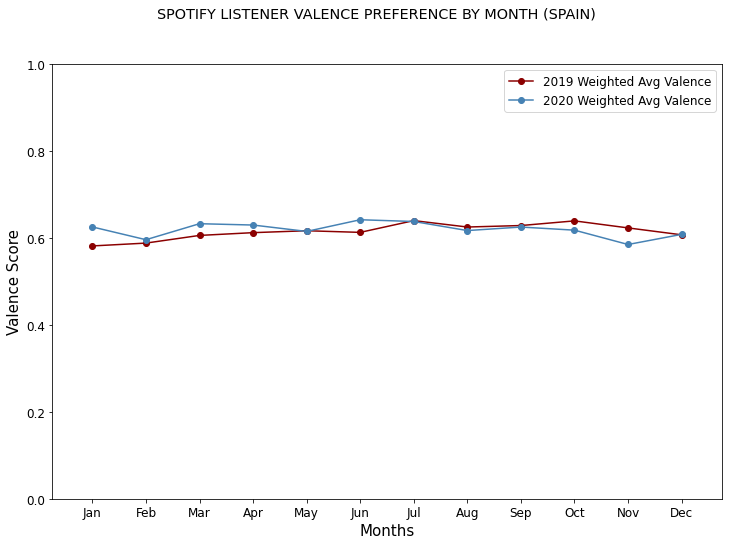

In [23]:
# Plot a comparison of 2019 2020 valence scores

# Set up lists to plot

valence_2019 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2019]

valence_2020 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2020]
valence_2020.drop('Year', inplace=True, axis=1)

fig= plt.figure(figsize=(12,8))                                      # Set up figure size
fig.suptitle('SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH (SPAIN)')         # Set up main title

y_axis = valence_2019['Valence_Stream%']
x_axis = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',                  # Set up x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(x_axis, valence_2019['Valence_Stream%'], label="2019 Weighted Avg Valence", marker='o', color='darkred')  # Plot 2019
plt.plot(x_axis, valence_2020['Valence_Stream%'], label="2020 Weighted Avg Valence", marker='o', color='steelblue')  # Plot 2020

plt.xlabel('Months')                                                 # Set up axis titles
plt.ylabel('Valence Score')

plt.xlim(-0.75, len(x_axis)-0.25)                                    # Set up axis limits
plt.ylim(0, 1)

plt.legend()                                                         # Include the legend

plt.show()

In [24]:
# Compare valence scores with covide infection rate

covid_df = pd.read_csv("input_files/owid-covid-data.csv")                # read the covid data file

country_covid_df = covid_df.loc[covid_df['location'] == 'Spain']   # Filter for country of your choice

country_covid_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
71322,ESP,Europe,Spain,2020-02-01,1.0,1.0,NaN,NaN,NaN,NaN,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.904
71323,ESP,Europe,Spain,2020-02-02,1.0,0.0,NaN,NaN,NaN,NaN,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.904
71324,ESP,Europe,Spain,2020-02-03,1.0,0.0,NaN,NaN,NaN,NaN,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.904
71325,ESP,Europe,Spain,2020-02-04,1.0,0.0,NaN,NaN,NaN,NaN,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.904
71326,ESP,Europe,Spain,2020-02-05,1.0,0.0,NaN,NaN,NaN,NaN,...,34272.36,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.904


In [25]:
# Filter data for 2020, and add a 'month' column

country_covid__2020_df = country_covid_df[country_covid_df.date.str.contains(r'2020.*')]

country_covid__2020_df['Month'] = ''

<ipython-input-25-69679f9e4cf0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_covid__2020_df['Month'] = ''


In [26]:
# Extract the month from the 'date' column and add it to the new 'month' column, for sorting later

for index, row in country_covid__2020_df.iterrows():
    month, = re.findall(f"2020-(\d\d)-", row['date'])
    country_covid__2020_df.at[index, 'Month'] = int(month)  

country_covid__2020_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
71322,ESP,Europe,Spain,2020-02-01,1.0,1.0,NaN,NaN,NaN,NaN,...,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.904,2
71323,ESP,Europe,Spain,2020-02-02,1.0,0.0,NaN,NaN,NaN,NaN,...,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.904,2
71324,ESP,Europe,Spain,2020-02-03,1.0,0.0,NaN,NaN,NaN,NaN,...,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.904,2
71325,ESP,Europe,Spain,2020-02-04,1.0,0.0,NaN,NaN,NaN,NaN,...,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.904,2
71326,ESP,Europe,Spain,2020-02-05,1.0,0.0,NaN,NaN,NaN,NaN,...,1.0,99.403,7.17,27.4,31.4,NaN,2.97,83.56,0.904,2


In [27]:
# Create a groupby to get the sum of new cases in each month

country_covid__2020_groupby = country_covid__2020_df.groupby(['Month'], as_index=False)['new_cases'].sum()
country_covid__2020_groupby


,Month,new_cases
0,2,45.0
1,3,95878.0
2,4,117512.0
3,5,26044.0
4,6,9792.0
5,7,39251.0
6,8,174336.0
7,9,306330.0
8,10,416490.0
9,11,462509.0


In [28]:
# TIP: This next section is to add missing months. In the case of New Zealand, there was no data for January
# For other countries, it might vary. Here's how I added January to the dataframe:

# No need to add january in Italy
# country_covid__2020_groupby.loc[-1] = [1, 0]             # This adds a 1 (month of January) in the first columne 
                                                         # index 0), in the last row of the dataframe. 

# country_covid__2020_groupby.index = country_covid__2020_groupby.index + 1   # shifts the index
country_covid__2020_groupby = country_covid__2020_groupby.sort_index()      # sorts by index

country_covid__2020_groupby = country_covid__2020_groupby.rename(columns={"new_cases": "New Cases"})

country_covid__2020_groupby

,Month,New Cases
0,2,45.0
1,3,95878.0
2,4,117512.0
3,5,26044.0
4,6,9792.0
5,7,39251.0
6,8,174336.0
7,9,306330.0
8,10,416490.0
9,11,462509.0


In [29]:
# Merge the dataframes into one nice comparison dataframe to scatter plot

country_covid_valence_df = pd.merge(valence_2020, country_covid__2020_groupby, on="Month")

country_covid_valence_df

,Month,Valence_Stream%,New Cases
0,2,0.595780,45.0
1,3,0.632578,95878.0
2,4,0.629511,117512.0
3,5,0.614825,26044.0
4,6,0.641679,9792.0
5,7,0.637669,39251.0
6,8,0.616821,174336.0
7,9,0.624891,306330.0
8,10,0.617730,416490.0
9,11,0.584769,462509.0


In [30]:
# Add a new cases per million column

country_polulation = 67886011  #TIP: This the population of New Zealand. Adjust for your country

country_covid_valence_df['New Cases Per Million'] = country_covid_valence_df['New Cases'] / country_polulation *1000000

country_covid_valence_df

,Month,Valence_Stream%,New Cases,New Cases Per Million
0,2,0.595780,45.0,0.662876
1,3,0.632578,95878.0,1412.338103
2,4,0.629511,117512.0,1731.019370
3,5,0.614825,26044.0,383.643104
4,6,0.641679,9792.0,144.241794
5,7,0.637669,39251.0,578.189813
6,8,0.616821,174336.0,2568.069584
7,9,0.624891,306330.0,4512.417146
8,10,0.617730,416490.0,6135.137326
9,11,0.584769,462509.0,6813.023673


ValueError: x and y must have same first dimension, but have shapes (12,) and (11,)

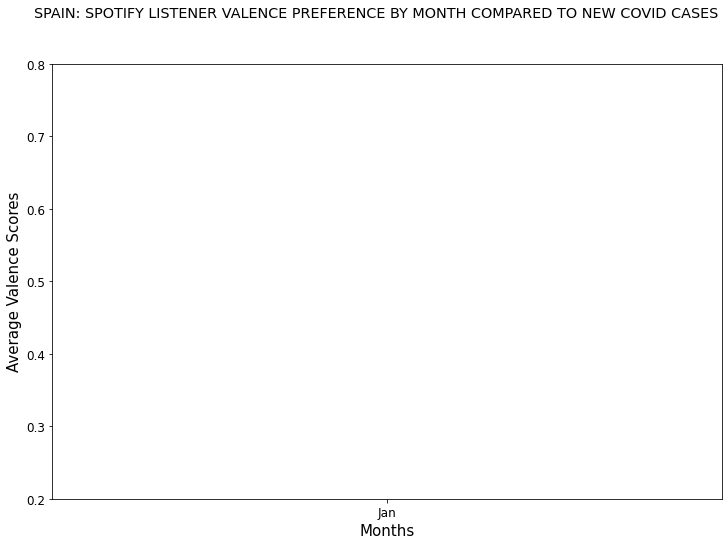

In [33]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

fig, ax1 = plt.subplots(figsize=(12,8))                   # Set up subplot figure and size
fig.suptitle('SPAIN: SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH COMPARED TO NEW COVID CASES')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',       # Set up shared x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax1.set_xlabel('Months')                

ax1.set_ylabel('Average Valence Scores')                  # Set up first plot 
ax1.set_ylim([.2, .8])

ax1_ydata = country_covid_valence_df['Valence_Stream%']
ax1.plot(months, ax1_ydata, label="Weighted Avg Valence Scores", marker='o', color='darkred')                       
                        
ax2 = ax1.twinx()                                         # Set up second plot 
ax2.set_ylabel('New Cases Per Month')
ax2_ydata = country_covid_valence_df['New Cases Per Million']
ax2.set_ylim([0, ax2_ydata.max()+20])
ax2.plot(months, ax2_ydata, label="New Covid Cases Per Million", marker='o', color='steelblue')


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()

In [34]:
# This is a mini function that adds a qualitative label to the correlation r score in the scatter plot

def r_label(r):
    abs_r = abs(r)
    if abs_r >= .8 : return "Very Strong"
    elif abs_r >= .6 : return "Strong"
    elif abs_r >= .4: return "Moderate"
    elif abs_r >= .2: return "Low"
    else: return "Negligible"

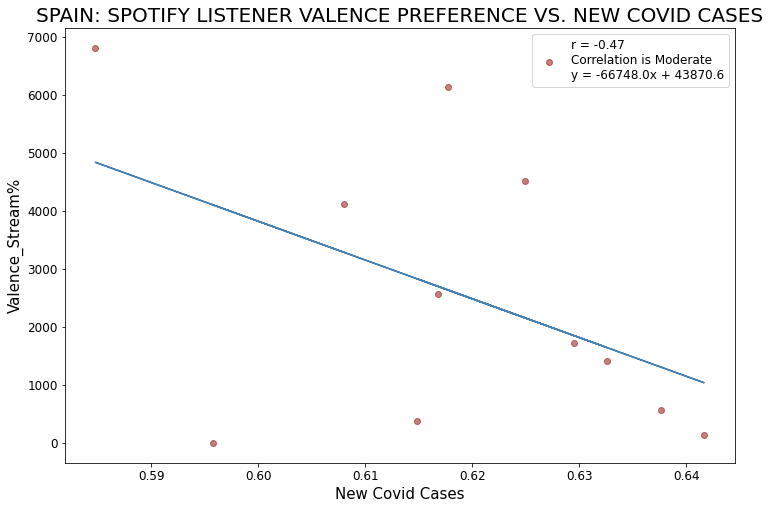

In [36]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

x_axis = country_covid_valence_df['Valence_Stream%']                                 # Set up axes
y_axis = country_covid_valence_df['New Cases Per Million']

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_axis, y_axis)  # Get elements of regression equation
regress_values = x_axis * slope + intercept                                  # Calculate regression values

plt.figure(figsize=(12, 8))
plt.title('SPAIN: SPOTIFY LISTENER VALENCE PREFERENCE VS. NEW COVID CASES') # CHANGE TITLE TO REFLECT YOUR COUNTRY

plt.xlabel(f"New Covid Cases")                                               # Set x axis label for subplot                  
plt.ylabel(f"Valence_Stream%")                                                       # Set title for subplot

r = round(stats.pearsonr(x_axis, y_axis)[0],2)                       # Calculate correlation coefficient
rlabel = r_label(r)                                                 # Call function to create a label for the r number

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))    # Ression formula

plt.scatter(x_axis, y_axis, facecolors="darkred",  alpha=.5,        # Plot the scatter chart
label=f"r = {r}\nCorrelation is {rlabel}\n{line_eq}" ) 

plt.plot(x_axis, regress_values, color="steelblue")                 # Plot the regression line    

plt.legend()                                                        # Add the legend
    
plt.savefig("output_files/valence_vs_newcases.png")                 # Save the png file   

plt.show()